# Specular Model Tester

## For seeing if we really can map to the cubes. 

This notebook/program is intended to do the following: take in a VIMS image (with geo data) and compare it to the specular viewing geometry data from the specular simulation. The result should itself be two images: one with pixels ranked by the "scale" required to get the best match, and then by the quality of said best match. This should give a highly visual and intiutive way of telling if the model is working--all lakes should have good values, everything else should have easliy discernable worse values. 

First, though, we need to load in everything. This program requires a cube, a geo file for that cube, and the specular viewing gometry data. 

In [7]:
#IMPORTS 
import csv
import math
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import scipy.misc
from scipy import ndimage
from pyvims import VIMS
import statistics
from matplotlib.colors import LogNorm

In [8]:
#READ-IN
usePyVIMS = False #Set to False to use cubeFilePath for a local file.
#Yes this was added to the code later so it is an absolute patchwork mess of a job. 
#NOTE: local files are MUCH faster.

#1) The Cube Itself.
cubeFilePath = r"C:\Users\deran\Desktop\CubeCSVDatabase\T104\CM_1787307197_1.cub.csv" #Kraken Mare

cubeFilePath = r"C:\Users\deran\Desktop\CubeCSVDatabase\T104\CM_1787307197_1.cub.csv"
#Here twice since I'm not saving everything. ...Man this entire notebook is a crime against neat code...

realCube = "1814944467_1"
cube = VIMS(realCube) #To avoid unecessary reading of data, comment this out when not using PyVIMS.
#Yes, I am lazy, why do you ask?

#Now we extract the axes file as well...
cubeAxesfp = cubeFilePath.removesuffix(".csv") + ".axes.csv"

#and THIS time we also need the geofile! We only need the IR one, but we should read the others in just in case.

cubeGeofpVIS = cubeFilePath.removesuffix(".cub.csv") + "_ir_geo.cub.csv"
cubeGeofpIR = cubeFilePath.removesuffix(".cub.csv") + "_vis_geo.cub.csv"
cubeGeofpVISaxes = cubeFilePath.removesuffix(".cub.csv") + "_ir_geo.cub.axes.csv"
cubeGeofpIRaxes = cubeFilePath.removesuffix(".cub.csv") + "_vis_geo.cub.axes.csv"

#Load all the axes in. 
xAxisCube = []
yAxisCube = []
zAxisCube = []

xAxisGeoIR = []
yAxisGeoIR = []
zAxisGeoIR = []

xAxisGeoVIS = []
yAxisGeoVIS = []
zAxisGeoVIS = []
if (usePyVIMS == False):
    with open(cubeAxesfp) as csv_file: #remember to tab.
            csv_reader = csv.reader(csv_file, delimiter=',')
            line_count = 0
            for row in csv_reader:
                i = 0
                L = len(row)
                while (i < L-1):
                    if (line_count == 0):
                        xAxisCube.append(row[i])
                    elif (line_count == 1):
                        yAxisCube.append(row[i])
                    elif (line_count == 2):
                        zAxisCube.append(row[i])
                    i = i+1
                line_count += 1
    with open(cubeGeofpVISaxes) as csv_file: #remember to tab.
            csv_reader = csv.reader(csv_file, delimiter=',')
            line_count = 0
            for row in csv_reader:
                i = 0
                L = len(row)
                while (i < L-1):
                    if (line_count == 0):
                        xAxisGeoVIS.append(row[i])
                    elif (line_count == 1):
                        yAxisGeoVIS.append(row[i])
                    elif (line_count == 2):
                        zAxisGeoVIS.append(row[i])
                    i = i+1
                line_count += 1
    with open(cubeGeofpIRaxes) as csv_file: #remember to tab.
            csv_reader = csv.reader(csv_file, delimiter=',')
            line_count = 0
            for row in csv_reader:
                i = 0
                L = len(row)
                while (i < L-1):
                    if (line_count == 0):
                        xAxisGeoIR.append(row[i])
                    elif (line_count == 1):
                        yAxisGeoIR.append(row[i])
                    elif (line_count == 2):
                        zAxisGeoIR.append(row[i])
                    i = i+1
                line_count += 1
else:
    #If we are using PyVIMS, we still need axes to be set, but in a different way.
    i=0
    zAxisGeoIR.append(0) 
    for x in cube.w:
        zAxisCube.append(cube.w[i])
        i = i+1
    i=0
    while (i < cube.shape[1]):
        xAxisCube.append(i)
        xAxisGeoIR.append(i)
        i = i+1
    i=0
    while (i < cube.shape[2]):
        yAxisCube.append(i)
        yAxisGeoIR.append(i)
        i = i+1
    i = 0
    while (i < 8):
        zAxisGeoIR.append(i)
        #No need to do VIS, quite unecessary.
        i = i+1
    
#Now we need to substantiate the data holders for everything. 

cubeData = [[[0 for x in range(len(zAxisCube))] for x in range(len(yAxisCube))] for x in range(len(xAxisCube))]
#geoVISData = [[[0 for x in range(len(zAxisGeoVIS))] for x in range(len(yAxisGeoVIS))] for x in range(len(xAxisGeoVIS))]
geoIRData = [[[0 for x in range(len(zAxisGeoIR))] for x in range(len(yAxisGeoIR))] for x in range(len(xAxisGeoIR))]

#The above holds the data of the cube itself. 

if (usePyVIMS == False):
    with open(cubeFilePath) as csv_file:
        csv_reader = csv.reader(csv_file, delimiter=',')
        line_count = 0
        i, j, k = 0, 0, 0
        for row in csv_reader:
            while (i < len(xAxisCube)):
                cubeData[i][j][k] = float(row[i])
                if (math.isnan(cubeData[i][j][k])):
                    cubeData[i][j][k] = 0 #We set nans to zero to allow plotting to take place, careful!
                elif (cubeData[i][j][k] < 0):
                    cubeData[i][j][k] = 0 #Negative values are nonsense.
                elif (cubeData[i][j][k] > 1):
                    cubeData[i][j][k] = 1 #Make saturation obvious? Keep it from overloading. 
                i = i + 1
            i = 0
            j = j + 1
            if (j >= len(yAxisCube)):
                j = 0
                k = k + 1
            line_count += 1
    #with open(cubeGeofpVIS) as csv_file:
    #    csv_reader = csv.reader(csv_file, delimiter=',')
    #    line_count = 0
    #    i, j, k = 0, 0, 0
    #    for row in csv_reader:
    #        while (i < len(xAxisGeoVIS)):
    #            geoVISData[i][j][k] = float(row[i])
    #            if (math.isnan(geoVISData[i][j][k])):
    #                geoVISData[i][j][k] = 0 #We set nans to zero to allow plotting to take place, careful!
    #            i = i + 1
    #        i = 0
    #        j = j + 1
    #        if (j >= len(yAxisGeoVIS)):
    #            j = 0
    #            k = k + 1
    #        line_count += 1
    with open(cubeGeofpIR) as csv_file:
        csv_reader = csv.reader(csv_file, delimiter=',')
        line_count = 0
        i, j, k = 0, 0, 0
        for row in csv_reader:
            while (i < len(xAxisGeoIR)):
                geoIRData[i][j][k] = float(row[i])
                if (math.isnan(geoIRData[i][j][k])):
                    geoIRData[i][j][k] = 0 #We set nans to zero to allow plotting to take place, careful!
                elif (geoIRData[i][j][k] < -1000):
                    geoIRData[i][j][k] = 0 #The default value is an extremely negative number. Scrub it.
                i = i + 1
            i = 0
            j = j + 1
            if (j >= len(yAxisGeoIR)):
                j = 0
                k = k + 1
            line_count += 1
else:
    #Okay so read in the data from the PyVIMS cube. 
    #The data itself is easy. Unfortunately we also need the GEO data, which is harder.
    #If we want the same code to work every time, we need to get each geo value 
    #to have the same values as a Jcube.
    #Each entry of a Jcube GEO contains the following:
    # 0: LAT, 1: LON, 2: Sample Resolution, 3: Line resolution, 4: Phase, 5: incidence, 
    #6: emission, 7: North Azimuth, 8: Limb Impact Parameter
    #Found in Detectors.c++ part of SRTC++ 
    #Now we don't need all these values, some of them will just be zero. But they all need to be set.
    
    i, j, k = 0,0,0
    while (i < len(zAxisCube)):
        j = 0
        while (j < len(xAxisCube)):
            k = 0
            while (k < len(yAxisCube)):
                cubeData[j][k][i] = cube[i+97][j][k] 
                if (i == 0):
                            
                    try:
                        c = round(cube.ground_lat[j][k]) #This should break if it isn't numeric.
                        #In fact this error is what gave us issues later.
                        geoIRData[j][k][0] = cube.ground_lat[j][k]
                    except:
                        #If not a number, zero it. 
                        geoIRData[j][k][0] = 0.
                    
                    try:
                        c = round(cube.ground_lon[j][k]) #This should break if it isn't numeric.
                        #In fact this error is what gave us issues later.
                        geoIRData[j][k][1] = cube.ground_lon[j][k]
                    except:
                        #If not a number, zero it. 
                        geoIRData[j][k][1] = 0.
                    
                    try:
                        c = round(cube.ground_res[j][k]) #This should break if it isn't numeric.
                        #In fact this error is what gave us issues later.
                        geoIRData[j][k][2] = cube.ground_res[j][k]
                    except:
                        #If not a number, zero it. 
                        geoIRData[j][k][2] = 0.
                        
                    geoIRData[j][k][3] = 0.
                    
                    try:
                        c = round(cube.ground_phase[j][k]) #This should break if it isn't numeric.
                        #In fact this error is what gave us issues later.
                        geoIRData[j][k][4] = cube.ground_phase[j][k]
                    except:
                        #If not a number, zero it. 
                        geoIRData[j][k][4] = 0.
                           
                    try:
                        c = round(cube.ground_inc[j][k]) #This should break if it isn't numeric.
                        #In fact this error is what gave us issues later.
                        geoIRData[j][k][5] = cube.ground_inc[j][k]
                    except:
                        #If not a number, zero it. 
                        geoIRData[j][k][5] = 0.

                    try:
                        c = round(cube.ground_eme[j][k]) #This should break if it isn't numeric.
                        #In fact this error is what gave us issues later.
                        geoIRData[j][k][6] = cube.ground_eme[j][k]
                    except:
                        #If not a number, zero it. 
                        geoIRData[j][k][6] = 0.
                            
                    try:
                        c = round(cube.ground_azi[j][k]) #This should break if it isn't numeric.
                        #In fact this error is what gave us issues later.
                        geoIRData[j][k][7] = cube.ground_azi[j][k]
                    except:
                        #If not a number, zero it. 
                        geoIRData[j][k][7] = 0.
                    
                    geoIRData[j][k][8] = 0.
                    
                if (math.isnan(cubeData[j][k][i])):
                    cubeData[j][k][i] = 0 #We set nans to zero to allow plotting to take place, careful!
                elif (cubeData[j][k][i] < 0):
                    cubeData[j][k][i] = 0 #Negative values are nonsense.
                elif (cubeData[j][k][i] > 1):
                    cubeData[j][k][i] = 1 #Make saturation obvious? Keep it from overloading.                 
                k = k+1
            j = j+1
        i = i+1

#We're gonna have to find some way to scrub all the geofiles...
print(geoIRData[0][0])
        
#That's the cube and geo data. 
#2) Now we have to load in the viewing geometry simulation data
#This is the same no matter what method we're using, as these are always local.

X = 21
Y = 19
Z = 37
#These are hard coded as I know exactly what files these are.

dataWin1 = [[[0 for x in range(Z)] for x in range(Y)] for x in range(X)] 
dataWin2 = [[[0 for x in range(Z)] for x in range(Y)] for x in range(X)] 
dataWin3 = [[[0 for x in range(Z)] for x in range(Y)] for x in range(X)] 
dataWin4 = [[[0 for x in range(Z)] for x in range(Y)] for x in range(X)] 
dataWin5 = [[[0 for x in range(Z)] for x in range(Y)] for x in range(X)] 
dataWin6 = [[[0 for x in range(Z)] for x in range(Y)] for x in range(X)] 
dataWin7 = [[[0 for x in range(Z)] for x in range(Y)] for x in range(X)] 
dataWin8 = [[[0 for x in range(Z)] for x in range(Y)] for x in range(X)]

with open('iephi_consolidate_0.93w.txt') as csv_file:
    csv_reader = csv.reader(csv_file, delimiter=',')
    line_count = 0
    i, j, k = 0, 0, 0
    for row in csv_reader:
        while (i < X):
            dataWin1[i][j][k] = float(row[i])
            if (math.isnan(dataWin1[i][j][k])):
                dataWin1[i][j][k] = 0
            i = i + 1
        i = 0
        j = j + 1
        if (j >= Y):
            j = 0
            k = k + 1
        line_count += 1
with open('iephi_consolidate_1.08w.txt') as csv_file:
    csv_reader = csv.reader(csv_file, delimiter=',')
    line_count = 0
    i, j, k = 0, 0, 0
    for row in csv_reader:
        while (i < X):
            dataWin2[i][j][k] = float(row[i])
            if (math.isnan(dataWin2[i][j][k])):
                dataWin2[i][j][k] = 0
            i = i + 1
        i = 0
        j = j + 1
        if (j >= Y):
            j = 0
            k = k + 1
        line_count += 1
with open('iephi_consolidate_1.27w.txt') as csv_file:
    csv_reader = csv.reader(csv_file, delimiter=',')
    line_count = 0
    i, j, k = 0, 0, 0
    for row in csv_reader:
        while (i < X):
            dataWin3[i][j][k] = float(row[i])
            if (math.isnan(dataWin3[i][j][k])):
                dataWin3[i][j][k] = 0
            i = i + 1
        i = 0
        j = j + 1
        if (j >= Y):
            j = 0
            k = k + 1
        line_count += 1
with open('iephi_consolidate_1.59w.txt') as csv_file:
    csv_reader = csv.reader(csv_file, delimiter=',')
    line_count = 0
    i, j, k = 0, 0, 0
    for row in csv_reader:
        while (i < X):
            dataWin4[i][j][k] = float(row[i])
            if (math.isnan(dataWin4[i][j][k])):
                dataWin4[i][j][k] = 0
            i = i + 1
        i = 0
        j = j + 1
        if (j >= Y):
            j = 0
            k = k + 1
        line_count += 1
with open('iephi_consolidate_2.01w.txt') as csv_file:
    csv_reader = csv.reader(csv_file, delimiter=',')
    line_count = 0
    i, j, k = 0, 0, 0
    for row in csv_reader:
        while (i < X):
            dataWin5[i][j][k] = float(row[i])
            if (math.isnan(dataWin5[i][j][k])):
                dataWin5[i][j][k] = 0
            i = i + 1
        i = 0
        j = j + 1
        if (j >= Y):
            j = 0
            k = k + 1
        line_count += 1
with open('iephi_consolidate_2.69w.txt') as csv_file:
    csv_reader = csv.reader(csv_file, delimiter=',')
    line_count = 0
    i, j, k = 0, 0, 0
    for row in csv_reader:
        while (i < X):
            dataWin6[i][j][k] = float(row[i])
            if (math.isnan(dataWin6[i][j][k])):
                dataWin6[i][j][k] = 0
            i = i + 1
        i = 0
        j = j + 1
        if (j >= Y):
            j = 0
            k = k + 1
        line_count += 1
with open('iephi_consolidate_2.79w.txt') as csv_file:
    csv_reader = csv.reader(csv_file, delimiter=',')
    line_count = 0
    i, j, k = 0, 0, 0
    for row in csv_reader:
        while (i < X):
            dataWin7[i][j][k] = float(row[i])
            if (math.isnan(dataWin7[i][j][k])):
                dataWin7[i][j][k] = 0
            i = i + 1
        i = 0
        j = j + 1
        if (j >= Y):
            j = 0
            k = k + 1
        line_count += 1
with open('iephi_consolidate_5.00w.txt') as csv_file:
    csv_reader = csv.reader(csv_file, delimiter=',')
    line_count = 0
    i, j, k = 0, 0, 0
    for row in csv_reader:
        while (i < X):
            dataWin8[i][j][k] = float(row[i])
            if (math.isnan(dataWin8[i][j][k])):
                dataWin8[i][j][k] = 0
            i = i + 1
        i = 0
        j = j + 1
        if (j >= Y):
            j = 0
            k = k + 1
        line_count += 1
        
#Now do it again for the Lambertian files. 

dataWin1L = [[[0 for x in range(Z)] for x in range(Y)] for x in range(X)] 
dataWin2L = [[[0 for x in range(Z)] for x in range(Y)] for x in range(X)] 
dataWin3L = [[[0 for x in range(Z)] for x in range(Y)] for x in range(X)] 
dataWin4L = [[[0 for x in range(Z)] for x in range(Y)] for x in range(X)] 
dataWin5L = [[[0 for x in range(Z)] for x in range(Y)] for x in range(X)] 
dataWin6L = [[[0 for x in range(Z)] for x in range(Y)] for x in range(X)] 
dataWin7L = [[[0 for x in range(Z)] for x in range(Y)] for x in range(X)] 
dataWin8L = [[[0 for x in range(Z)] for x in range(Y)] for x in range(X)]

with open('iephi_consolidate_0.93wL.txt') as csv_file:
    csv_reader = csv.reader(csv_file, delimiter=',')
    line_count = 0
    i, j, k = 0, 0, 0
    for row in csv_reader:
        while (i < X):
            dataWin1L[i][j][k] = float(row[i])
            if (math.isnan(dataWin1L[i][j][k])):
                dataWin1L[i][j][k] = 0
            i = i + 1
        i = 0
        j = j + 1
        if (j >= Y):
            j = 0
            k = k + 1
        line_count += 1
with open('iephi_consolidate_1.08wL.txt') as csv_file:
    csv_reader = csv.reader(csv_file, delimiter=',')
    line_count = 0
    i, j, k = 0, 0, 0
    for row in csv_reader:
        while (i < X):
            dataWin2L[i][j][k] = float(row[i])
            if (math.isnan(dataWin2L[i][j][k])):
                dataWin2L[i][j][k] = 0
            i = i + 1
        i = 0
        j = j + 1
        if (j >= Y):
            j = 0
            k = k + 1
        line_count += 1
with open('iephi_consolidate_1.27wL.txt') as csv_file:
    csv_reader = csv.reader(csv_file, delimiter=',')
    line_count = 0
    i, j, k = 0, 0, 0
    for row in csv_reader:
        while (i < X):
            dataWin3L[i][j][k] = float(row[i])
            if (math.isnan(dataWin3L[i][j][k])):
                dataWin3L[i][j][k] = 0
            i = i + 1
        i = 0
        j = j + 1
        if (j >= Y):
            j = 0
            k = k + 1
        line_count += 1
with open('iephi_consolidate_1.59wL.txt') as csv_file:
    csv_reader = csv.reader(csv_file, delimiter=',')
    line_count = 0
    i, j, k = 0, 0, 0
    for row in csv_reader:
        while (i < X):
            dataWin4L[i][j][k] = float(row[i])
            if (math.isnan(dataWin4L[i][j][k])):
                dataWin4L[i][j][k] = 0
            i = i + 1
        i = 0
        j = j + 1
        if (j >= Y):
            j = 0
            k = k + 1
        line_count += 1
with open('iephi_consolidate_2.01wL.txt') as csv_file:
    csv_reader = csv.reader(csv_file, delimiter=',')
    line_count = 0
    i, j, k = 0, 0, 0
    for row in csv_reader:
        while (i < X):
            dataWin5L[i][j][k] = float(row[i])
            if (math.isnan(dataWin5L[i][j][k])):
                dataWin5L[i][j][k] = 0
            i = i + 1
        i = 0
        j = j + 1
        if (j >= Y):
            j = 0
            k = k + 1
        line_count += 1
with open('iephi_consolidate_2.69wL.txt') as csv_file:
    csv_reader = csv.reader(csv_file, delimiter=',')
    line_count = 0
    i, j, k = 0, 0, 0
    for row in csv_reader:
        while (i < X):
            dataWin6L[i][j][k] = float(row[i])
            if (math.isnan(dataWin6L[i][j][k])):
                dataWin6L[i][j][k] = 0
            i = i + 1
        i = 0
        j = j + 1
        if (j >= Y):
            j = 0
            k = k + 1
        line_count += 1
with open('iephi_consolidate_2.79wL.txt') as csv_file:
    csv_reader = csv.reader(csv_file, delimiter=',')
    line_count = 0
    i, j, k = 0, 0, 0
    for row in csv_reader:
        while (i < X):
            dataWin7L[i][j][k] = float(row[i])
            if (math.isnan(dataWin7L[i][j][k])):
                dataWin7L[i][j][k] = 0
            i = i + 1
        i = 0
        j = j + 1
        if (j >= Y):
            j = 0
            k = k + 1
        line_count += 1
with open('iephi_consolidate_5.00wL.txt') as csv_file:
    csv_reader = csv.reader(csv_file, delimiter=',')
    line_count = 0
    i, j, k = 0, 0, 0
    for row in csv_reader:
        while (i < X):
            dataWin8L[i][j][k] = float(row[i])
            if (math.isnan(dataWin8L[i][j][k])):
                dataWin8L[i][j][k] = 0
            i = i + 1
        i = 0
        j = j + 1
        if (j >= Y):
            j = 0
            k = k + 1
        line_count += 1

#Everything should be read in now. However we do need to scan the wavelength values of the windows.

windowum = [0.933078, 1.08183, 1.27813, 1.59018, 2.01781, 2.69620, 2.79889, 5.00576]
#Now we need to dynamically find the indeces where this is true. 
windowInd = [0,0,0,0,0,0,0,0]
i = 0
while (i < 8):
    j = 0
    while (j < len(zAxisCube)):
        if (float(zAxisCube[j]) < windowum[i] and float(zAxisCube[j+1]) > windowum[i]):
            #if (windowum[i] - float(zAxisCube[j]) < float(zAxisCube[j+1]) - windowum[i]):
            windowInd[i] = j+1
                #This mess makes sure our index values match the "bestcolor" index numbers. 
                
            #else:
                #windowInd[i] = j+1
            j = len(zAxisCube)
        j = j + 1
    i = i+1
print(windowInd)
print(len(xAxisCube),len(yAxisCube))
print(len(cubeData), len(cubeData[0]), len(cubeData[0][0]))

[79.347755, 321.66037, 10.326665, 12.028967, 99.33049, 59.366871, 41.58054, 40.211281]
[80, 108, 120, 139, 165, 206, 212, 344]
64 64
64 64 352


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.08768839285714289..1.728699107142858].


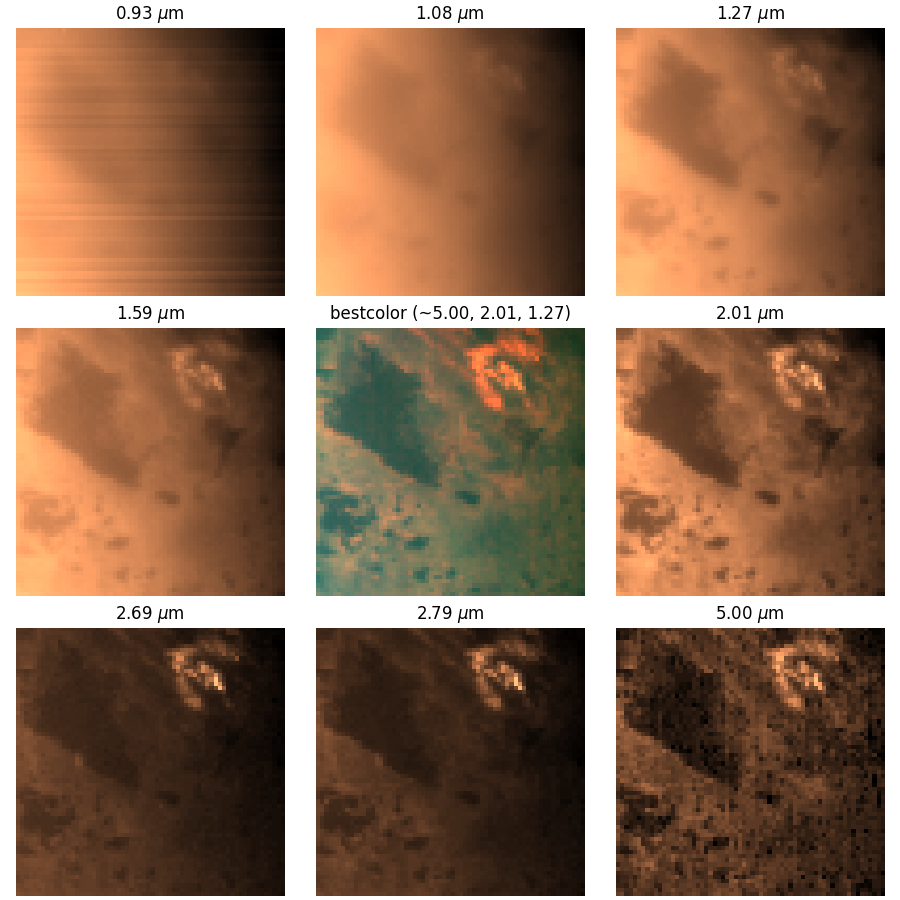

In [9]:
#DISPLAY: CUBE
#Just to show the cube we are reading in.
fig, axs = plt.subplots(3,3, figsize = (9,9), layout = "constrained") 

temp = np.transpose(cubeData)

#Windows are, according to lambertian_wholedisk:
#0.933078, 1.08183, 1.27813, 1.59018, 2.01781, 2.69620, 2.79889, 5.00576

c1 = axs[0,0].imshow((np.transpose(temp[windowInd[0]])), cmap="copper")
c2 = axs[0,1].imshow((np.transpose(temp[windowInd[1]])), cmap="copper")
c3 = axs[0,2].imshow((np.transpose(temp[windowInd[2]])), cmap="copper")
c4 = axs[1,0].imshow((np.transpose(temp[windowInd[3]])), cmap="copper")
c5 = axs[1,2].imshow((np.transpose(temp[windowInd[4]])), cmap="copper")
c6 = axs[2,0].imshow((np.transpose(temp[windowInd[5]])), cmap="copper")
c7 = axs[2,1].imshow((np.transpose(temp[windowInd[6]])), cmap="copper")
c8 = axs[2,2].imshow((np.transpose(temp[windowInd[7]])), cmap="copper")
#fig.colorbar(c4, ax=cax, label='High') 
#fig.tight_layout(pad=1.0)
axs[0,0].axis('off')
axs[0,1].axis('off')
axs[0,2].axis('off')
axs[1,0].axis('off')
axs[1,1].axis('off')
axs[1,2].axis('off')
axs[2,0].axis('off')
axs[2,1].axis('off')
axs[2,2].axis('off')
axs[1,1].axis('off')

#COLOR
#One of our colors is an average in titancolor2, so we need to grab it::
ofs = 96 #offset for when we don't have a "full" cube. It should always be 96.

if (len(zAxisCube) > 256):
    ave = (temp[336]+temp[337]+temp[338]+temp[339]+temp[340]+temp[341]
          +temp[342]+temp[343]+temp[344]+temp[345]+temp[346]+temp[347]
          +temp[348]+temp[349]+temp[350]+temp[351])/16.
    mod = 1.

    # set R, G, and B
    R = ave/(mod*1.12/16.) #Average dealing shenanigans.
    G = temp[165]/(mod*0.22)
    B = (temp[120]-0.03)/(mod*0.37)
else:
    ave = (temp[336-ofs]+temp[337-ofs]+temp[338-ofs]+temp[339-ofs]+temp[340-ofs]+temp[341-ofs]
          +temp[342-ofs]+temp[343-ofs]+temp[344-ofs]+temp[345-ofs]+temp[346-ofs]+temp[347-ofs]
          +temp[348-ofs]+temp[349-ofs]+temp[350-ofs]+temp[351-ofs])/16.
    mod = 1.

    # set R, G, and B
    R = ave/(mod*1.12/16.) #Average dealing shenanigans.
    G = temp[165-ofs]/(mod*0.22)
    B = (temp[120-ofs]-0.03)/(mod*0.37)
#B's value can introduce negatives, remove them.
i,j = 0,0
for x in B:
    j=0
    for y in x:
        if (y < 0):
            B[i][j] = 0
        j = j+1
    i = i+1

# Now we need to combine them in the correct form: xyc, that is, x, y, then color value. 
colorData = [np.transpose(R),np.transpose(G),np.transpose(B)] # arranged in cyx.
colorData = np.transpose(colorData) #arranged in xyc
#This also introduces a rotation of the image by -90 degrees. 

image = axs[1,1].imshow(ndimage.rotate(colorData,90),origin="lower") 
#The rotation is undone here using rotate(). 

axs[0,0].set(title="0.93 $\mu$m")
axs[0,1].set(title="1.08 $\mu$m")
axs[0,2].set(title="1.27 $\mu$m")
axs[1,0].set(title="1.59 $\mu$m")
axs[1,1].set(title="bestcolor (~5.00, 2.01, 1.27)")
axs[1,2].set(title="2.01 $\mu$m")
axs[2,0].set(title="2.69 $\mu$m")
axs[2,1].set(title="2.79 $\mu$m")
axs[2,2].set(title="5.00 $\mu$m")

plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.08768839285714289..1.728699107142858].


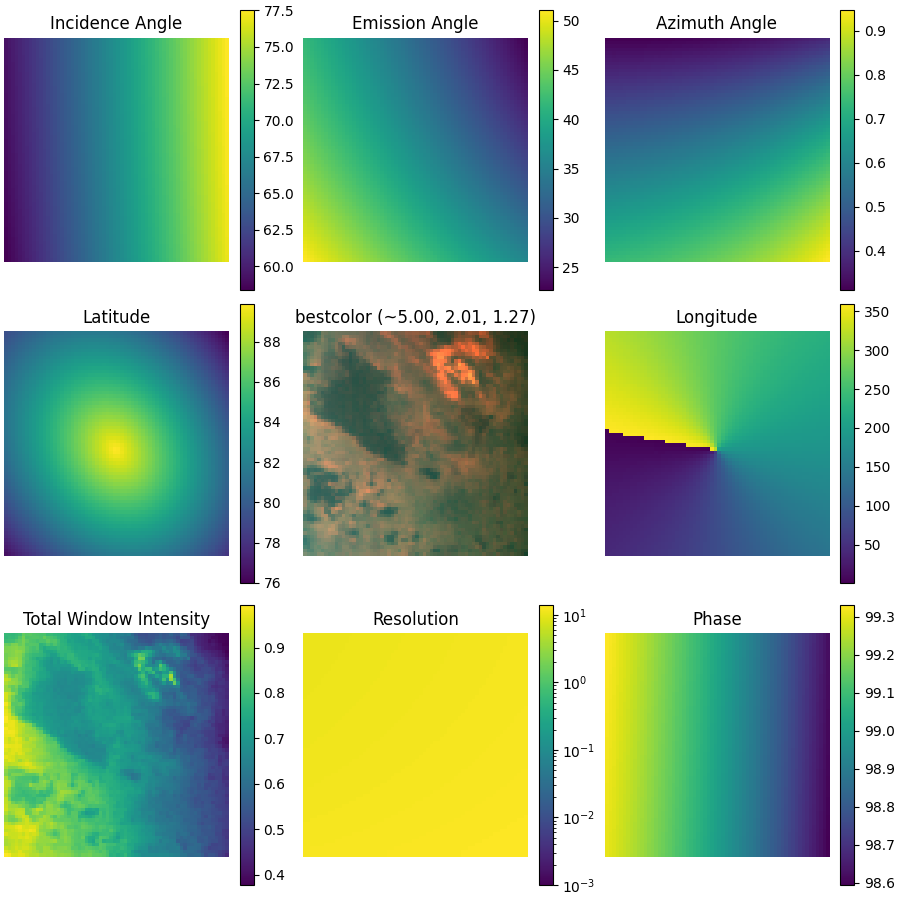

In [10]:
#METADATA 
#Same arrangement as above, but examinming the metadata instead.

#DISPLAY: CUBE
#Just to show the cube we are reading in.
fig, axs = plt.subplots(3,3, figsize = (9,9), layout = "constrained") 

#Windows are, according to lambertian_wholedisk:
#0.933078, 1.08183, 1.27813, 1.59018, 2.01781, 2.69620, 2.79889, 5.00576

c1 = axs[0,0].imshow(np.transpose(np.transpose(geoIRData)[5]), cmap="viridis")
fig.colorbar(c1, ax=axs[0][0])
c2 = axs[0,1].imshow(np.transpose(np.transpose(geoIRData)[6]), cmap="viridis")
fig.colorbar(c2, ax=axs[0][1])
#azimuth moved, there's a conditional we need to deal with.
c4 = axs[1,0].imshow(np.transpose(np.transpose(geoIRData)[0]), cmap="viridis")
fig.colorbar(c4, ax=axs[1][0])
c5 = axs[1,2].imshow(np.transpose(np.transpose(geoIRData)[1]), cmap="viridis")
fig.colorbar(c5, ax=axs[1][2])
#NormFactor moved elsewhere, more steps required.
c7 = axs[2,1].imshow(np.transpose(np.transpose(geoIRData)[2]), cmap="viridis", norm=LogNorm(vmin=0.001))
fig.colorbar(c7, ax=axs[2][1])
c8 = axs[2,2].imshow(np.transpose(np.transpose(geoIRData)[4]), cmap="viridis")
fig.colorbar(c8, ax=axs[2][2])

#NormFactor needs to know the brightness of every pixel.
#renamed Total Window Intensity. It really is just the addition of the 8 atmospheric windows.
normPixels = np.transpose(np.transpose(geoIRData)[6])*0.
i,j = 0,0
while (i < len(xAxisCube)):
    j = 0
    while (j < len(yAxisCube)):
        pixelWindows = [0.,0.,0.,0.,0.,0.,0.,0.]
        k = 0
        #print(i,j, len(xAxisCube), len(yAxisCube))
        while (k < 8):
            pixelWindows[k] = temp[windowInd[k]][j][i] #Backward since temp itself is in yx.
            k = k+1
        totalPixelLight = 0.
        for item in pixelWindows:
            totalPixelLight = totalPixelLight + item
        normPixels[i][j] = totalPixelLight
        j = j+1
    i = i+1    
    
c6 = axs[2,0].imshow(normPixels, cmap="viridis")
fig.colorbar(c6, ax=axs[2][0])

#Azimuth is dealt with differently when using Jcube and PyVIMS
cubeAzimuth = 180 - np.transpose(np.transpose(geoIRData)[7])
if (usePyVIMS == False):
    i,j = 0,0
    while (i < len(xAxisCube)):
        j = 0
        while (j < len(yAxisCube)):
            p = geoIRData[i][j][4] #used to calculate azimuth.
            inci = geoIRData[i][j][5]
            emis = geoIRData[i][j][6]
            ratio = -(np.cos(np.radians(p)) - np.cos(np.radians(inci))* np.cos(np.radians(emis)))/(np.sin(np.radians(inci))*np.sin(np.radians(emis)))
            azim = np.arccos(ratio) 
            #Of course, this might be nan-ing. All the nans need their own values.
            if((math.isnan(azim) == True) and (ratio>0.)):
                azim = 0.
            elif((math.isnan(azim) == True) and (ratio<0.)):
                azim = 0.
            elif((inci==0) and (emis==0)):
                azim = 0.
            elif(math.isnan(azim) == True):
                print("Well you broke it, great. (Azimuth is nan, but could not be set to anything else.)")
            cubeAzimuth[i][j] = azim
            j = j+1
        i = i+1   


    
c3 = axs[0,2].imshow(cubeAzimuth, cmap="viridis")
fig.colorbar(c3, ax=axs[0][2])

axs[0,0].axis('off')
axs[0,1].axis('off')
axs[0,2].axis('off')
axs[1,0].axis('off')
axs[1,1].axis('off')
axs[1,2].axis('off')
axs[2,0].axis('off')
axs[2,1].axis('off')
axs[2,2].axis('off')
axs[1,1].axis('off')

image = axs[1,1].imshow(ndimage.rotate(colorData,90),origin="lower") 
#The rotation is undone here using rotate(). 

axs[0,0].set(title="Incidence Angle")
axs[0,1].set(title="Emission Angle")
axs[0,2].set(title="Azimuth Angle")
axs[1,0].set(title="Latitude")
axs[1,1].set(title="bestcolor (~5.00, 2.01, 1.27)")
axs[1,2].set(title="Longitude")
axs[2,0].set(title="Total Window Intensity")
axs[2,1].set(title="Resolution")
axs[2,2].set(title="Phase")

plt.show()

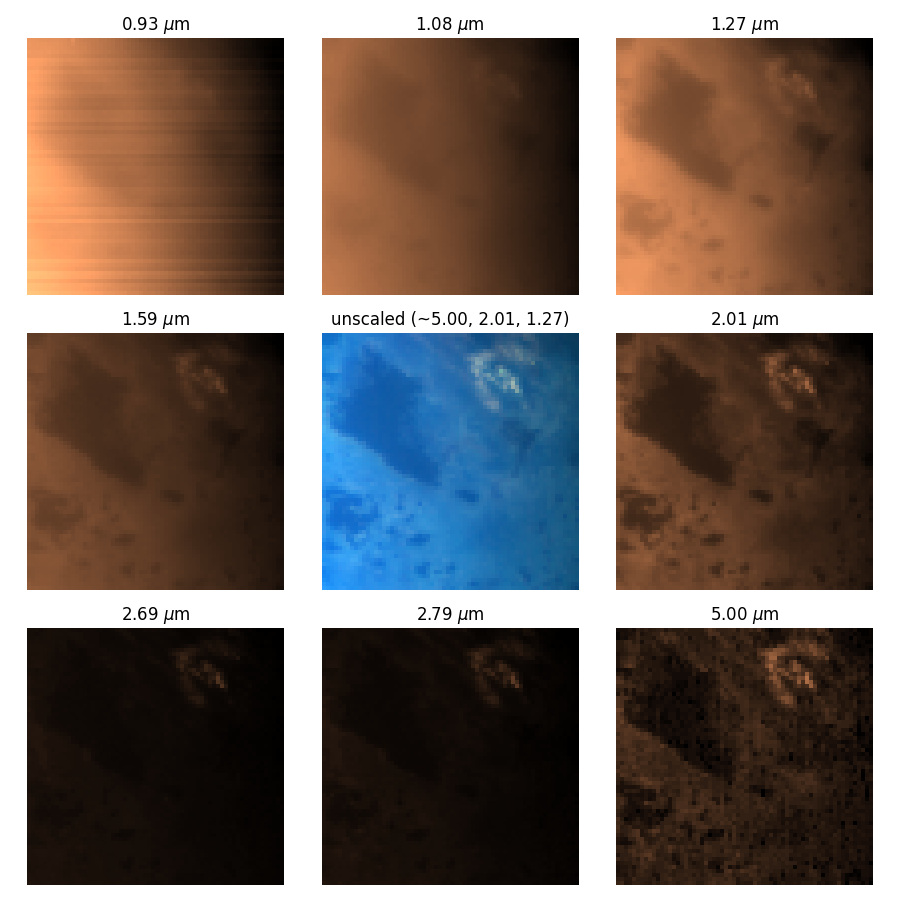

In [11]:
fig, axs = plt.subplots(3,3, figsize = (9,9), layout="tight") 
temp = np.transpose(cubeData)

#First, we need to find the maximum of all the data. This will take some finagling.
allData = [temp[windowInd[0]],temp[windowInd[1]],temp[windowInd[2]],temp[windowInd[3]],
          temp[windowInd[4]],temp[windowInd[5]],temp[windowInd[6]],temp[windowInd[7]]]

maximum =  np.amax(allData)

#Recolor the color, except make it unscaled
ofs = 96 #offset for when we don't have a "full" cube. It should always be 96.

if (len(zAxisCube) > 256):
    ave = (temp[336]+temp[337]+temp[338]+temp[339]+temp[340]+temp[341]
          +temp[342]+temp[343]+temp[344]+temp[345]+temp[346]+temp[347]
          +temp[348]+temp[349]+temp[350]+temp[351])/16.
    mod = 1.

    # set R, G, and B
    R = ave #Average dealing shenanigans.
    G = temp[165]
    B = temp[120]
else:
    ave = (temp[336-ofs]+temp[337-ofs]+temp[338-ofs]+temp[339-ofs]+temp[340-ofs]+temp[341-ofs]
          +temp[342-ofs]+temp[343-ofs]+temp[344-ofs]+temp[345-ofs]+temp[346-ofs]+temp[347-ofs]
          +temp[348-ofs]+temp[349-ofs]+temp[350-ofs]+temp[351-ofs])/16.
    mod = 1.

    # set R, G, and B
    R = ave
    G = temp[165-ofs]
    B = temp[120-ofs]
#B's value can introduce negatives, remove them.
i,j = 0,0
for x in B:
    j=0
    for y in x:
        if (y < 0):
            B[i][j] = 0
        j = j+1
    i = i+1

# Now we need to combine them in the correct form: xyc, that is, x, y, then color value. 
colorData = [np.transpose(R),np.transpose(G),np.transpose(B)] # arranged in cyx. I thought RGB needed to be transposed but evidentialy not. Hmm.
colorData = np.transpose(colorData)/ (np.amax(colorData)) #arranged in xyc
    
c1 = axs[0,0].imshow(np.transpose(temp[windowInd[0]]), cmap="copper",vmax = maximum)
c2 = axs[0,1].imshow(np.transpose(temp[windowInd[1]]), cmap="copper",vmax = maximum)
c3 = axs[0,2].imshow(np.transpose(temp[windowInd[2]]), cmap="copper",vmax = maximum)
c4 = axs[1,0].imshow(np.transpose(temp[windowInd[3]]), cmap="copper",vmax = maximum)
c5 = axs[1,2].imshow(np.transpose(temp[windowInd[4]]), cmap="copper",vmax = maximum)
c6 = axs[2,0].imshow(np.transpose(temp[windowInd[5]]), cmap="copper",vmax = maximum)
c7 = axs[2,1].imshow(np.transpose(temp[windowInd[6]]), cmap="copper",vmax = maximum)
c8 = axs[2,2].imshow(np.transpose(temp[windowInd[7]]), cmap="copper",vmax = maximum)
image = axs[1,1].imshow(ndimage.rotate(colorData,90), origin="lower") 
#fig.colorbar(c4, ax=cax, label='High') 
#fig.tight_layout(pad=1.0)
axs[0,0].axis('off')
axs[0,1].axis('off')
axs[0,2].axis('off')
axs[1,0].axis('off')
axs[1,1].axis('off')
axs[1,2].axis('off')
axs[2,0].axis('off')
axs[2,1].axis('off')
axs[2,2].axis('off')



axs[0,0].set(title="0.93 $\mu$m")
axs[0,1].set(title="1.08 $\mu$m")
axs[0,2].set(title="1.27 $\mu$m")
axs[1,0].set(title="1.59 $\mu$m")
axs[1,1].set(title="unscaled (~5.00, 2.01, 1.27)")
axs[1,2].set(title="2.01 $\mu$m")
axs[2,0].set(title="2.69 $\mu$m")
axs[2,1].set(title="2.79 $\mu$m")
axs[2,2].set(title="5.00 $\mu$m")

plt.show()

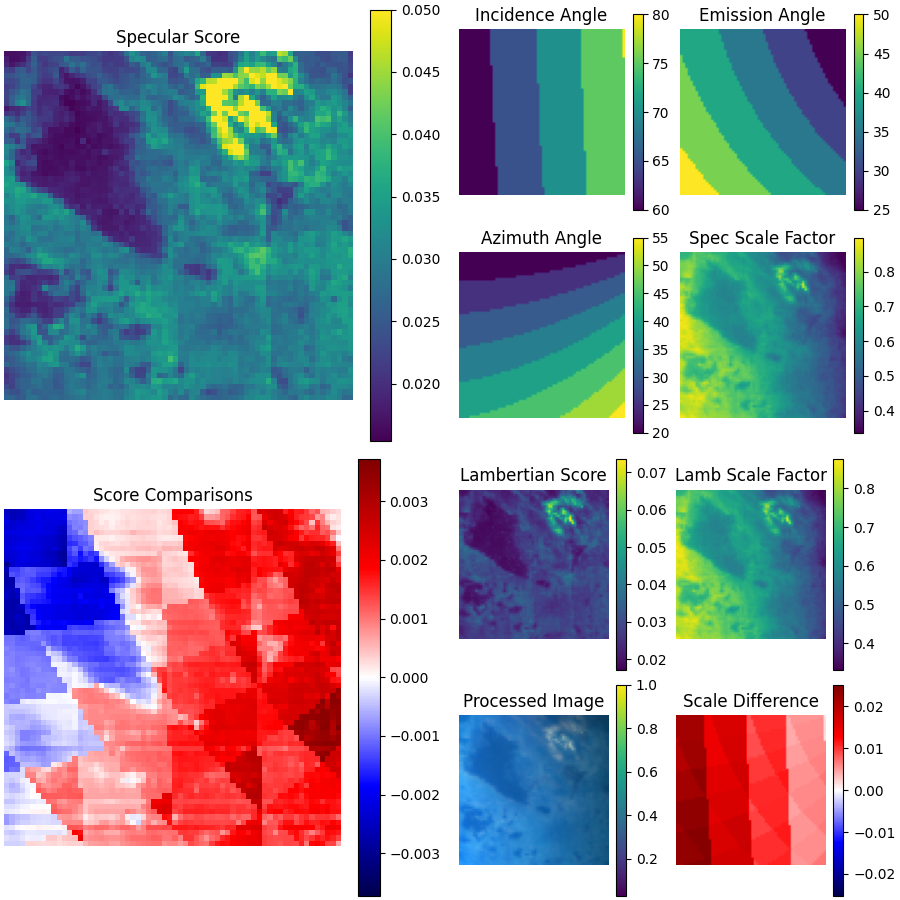

In [12]:
%matplotlib ipympl
#Note: this is cool and all but not as helpful as you might think. Sometimes
#it can easily discern between sea and land, other times not. 
#Not great for identifying edge cases. 

method = "art"

# "mul" multiplies everything by a scale factor for testing.
# "add" adds an offset to the data for testing. THIS ONE IS BAD DO NOT USE.
# "art" is the custom bizarre method. "artificial". 
# Both are chi-squared type tests. 

#CREATE IMAGE!
#Goal: two images showcasing how close each pixel is to model. 

fig = plt.figure(figsize = (9,9), layout="constrained")

subfigs = fig.subfigures(2, 2, width_ratios=[1,1])

axA = subfigs[0][0].subplots()
axB = subfigs[1][0].subplots()
axC = subfigs[0][1].subplots(2,2)
axD = subfigs[1][1].subplots(2,2)

#First, the data our final image holds.
modelDiff = np.transpose(temp[0]*0.) #How far we have to shift
modelAcc = np.transpose(temp[0]*0.) #Value of best fit
modelDiffL = np.transpose(temp[0]*0.) #Lambertian versions of the above.
modelAccL = np.transpose(temp[0]*0.) 

angleI = np.transpose(temp[0]*0.)
angleA = np.transpose(temp[0]*0.)
angleE = np.transpose(temp[0]*0.)
#Transposed for a reason. "temp" is in wyx, and yx is not the arrangement we want for the image, we want xy.

#Up next is the bulk of the program, a massive loop that iterates over every single pixel 
#and records the appropriate values.
i,j = 0,0
while (i < len(xAxisCube)):
    j = 0
    while (j < len(yAxisCube)):
        #We have selected a pixel at this point.
        #First, grab the data for all 8 windows. Store it in an array.
        pixelWindows = [0.,0.,0.,0.,0.,0.,0.,0.]
        geomWindows = [0.,0.,0.,0.,0.,0.,0.,0.]
        geomWindowsL = [0.,0.,0.,0.,0.,0.,0.,0.]
        k = 0
        #print(i,j, len(xAxisCube), len(yAxisCube))
        while (k < 8):
            pixelWindows[k] = temp[windowInd[k]][j][i] #Backward since temp itself is in yx.
            k = k+1
        #Now we need to find the geometries for each pixel. Specifically:
        #incidence, emission, azimuth. 
        #These are contained within the geofiles.
        inci = geoIRData[i][j][5]
        emis = geoIRData[i][j][6]
        azim = 0.
        if (usePyVIMS == True):
            azim = 180 - geoIRData[i][j][7] #The azim is evidentially defined in the reverse manner
            # in the pyVIMS database
        else:
            #Azimuth formula from Jason Barnes' phasecurve.c++
            p = geoIRData[i][j][4] #used to calculate azimuth.
            ratio = -(np.cos(np.radians(p)) - np.cos(np.radians(inci))* np.cos(np.radians(emis)))/(np.sin(np.radians(inci))*np.sin(np.radians(emis)))
            azim = np.arccos(ratio)            

        #Of course, this might be nan-ing. All the nans need their own values.
        if((math.isnan(azim) == True) and (ratio>0.)):
            azim = 0.
        elif((math.isnan(azim) == True) and (ratio<0.)):
            azim = 0.
        elif((inci==0) and (emis==0)):
            azim = 0.
        elif(math.isnan(azim) == True):
            print("Well you broke it, great. (Azimuth is nan, but could not be set to anything else.)")
        
        #We are now armed with i, e, and phi(azimuth); in addition to the 8 wavelengths. 
        #Each pixel contains 11 pieces of information. 
        #Now we need to grab the comparison information from the viewing geometries.
        #The viewing geometries are in divisions of five degrees, so first all values need to be rounded.
        inci = round(inci/5)*5
        emis = round(emis/5)*5
        if (usePyVIMS == True): azim = round(azim/5)*5
        else: azim = round(np.degrees(azim)/5)*5
        #Sometimes data is corrupted or feeds us nonsense. We can force it to be reasonable. 
        if (inci < 0):
            inci = 0
        elif (inci > 100):
            inci = 100
        if (emis < 0):
            emis = 0
        elif (emis > 90):
            emis = 90
        if (azim < 0):
            azim = 0
        if (azim > 180):
            azim = 180
        
        #print(inci, emis, azim)
        
        geomWindows[0] = dataWin1[int(inci / 5)][int(emis / 5)][int(azim / 5)]
        geomWindows[1] = dataWin2[int(inci / 5)][int(emis / 5)][int(azim / 5)]
        geomWindows[2] = dataWin3[int(inci / 5)][int(emis / 5)][int(azim / 5)]
        geomWindows[3] = dataWin4[int(inci / 5)][int(emis / 5)][int(azim / 5)]
        geomWindows[4] = dataWin5[int(inci / 5)][int(emis / 5)][int(azim / 5)]
        geomWindows[5] = dataWin6[int(inci / 5)][int(emis / 5)][int(azim / 5)]
        geomWindows[6] = dataWin7[int(inci / 5)][int(emis / 5)][int(azim / 5)]
        geomWindows[7] = dataWin8[int(inci / 5)][int(emis / 5)][int(azim / 5)]            
        geomWindowsL[0] = dataWin1L[int(inci / 5)][int(emis / 5)][int(azim / 5)]
        geomWindowsL[1] = dataWin2L[int(inci / 5)][int(emis / 5)][int(azim / 5)]
        geomWindowsL[2] = dataWin3L[int(inci / 5)][int(emis / 5)][int(azim / 5)]
        geomWindowsL[3] = dataWin4L[int(inci / 5)][int(emis / 5)][int(azim / 5)]
        geomWindowsL[4] = dataWin5L[int(inci / 5)][int(emis / 5)][int(azim / 5)]
        geomWindowsL[5] = dataWin6L[int(inci / 5)][int(emis / 5)][int(azim / 5)]
        geomWindowsL[6] = dataWin7L[int(inci / 5)][int(emis / 5)][int(azim / 5)]
        geomWindowsL[7] = dataWin8L[int(inci / 5)][int(emis / 5)][int(azim / 5)]
        #Maybe should have made the viewing geometry data in one array... oh well.
        #Anyway, that's all the data we need. Now comes the actual processing steps!
        #First: determine a scaling factor that will minimize the differences across
        #all eight windows.
        scale = 0 #start at 0, work up to 10. This is decidedly overzealous.
        tempScale = 0 #For adjusting.
        score = 1000 #To determine which is the best. Absurdly large at the start.
        scoreL = 1000 #Lambertian as well.
        scaleL = 0
        
        floorVal = np.amin(geomWindows)  
        floorValL = np.amin(geomWindowsL)
        if (floorValL > floorVal):
            floorVal = floorVal
        #Get the smallest value so we can start at the lowest
        #offset when using the "add" method
        
        if (method == "mul"):
            while (tempScale <= 100):
                tempScore = 0
                tempScoreL = 0
                k = 0
                while (k < 8):
                    tempScore = tempScore + ((pixelWindows[k]-geomWindows[k]*tempScale)
                                             *(pixelWindows[k]-geomWindows[k]*tempScale))/(geomWindows[k]*tempScale)
                    tempScoreL = tempScoreL + ((pixelWindows[k]-geomWindowsL[k]*tempScale)
                                               *(pixelWindows[k]-geomWindowsL[k]*tempScale))/(geomWindowsL[k]*tempScale)
                    #The score is just the chi-squared number at whatever scale we're dealing with
                    k = k+1
                if (tempScore < score):
                    score = tempScore #Lower score is better!
                    scale = tempScale
                if (tempScoreL < scoreL):
                    scoreL = tempScoreL
                    scaleL = tempScale
                tempScale = tempScale + 1           
        elif (method == "add"):
            while (tempScale <= 1):
                tempScore = 0
                tempScoreL = 0
                k = 0
                while (k < 8):
                    tempScore = tempScore + ((pixelWindows[k]-geomWindows[k]-(tempScale-floorVal))
                                             *(pixelWindows[k]-geomWindows[k]-(tempScale-floorVal)))/(geomWindows[k]+(tempScale-floorVal))
                    tempScoreL = tempScoreL + ((pixelWindows[k]-geomWindowsL[k]-(tempScale-floorVal))
                                               *(pixelWindows[k]-geomWindowsL[k]-(tempScale-floorVal)))/(geomWindowsL[k]+(tempScale-floorVal))

                    tempScore = tempScore + abs(geomWindows[k]+(tempScale-floorVal) - pixelWindows[k])
                    tempScoreL = tempScoreL + abs(geomWindowsL[k]+(tempScale-floorVal) - pixelWindows[k])
                    #The score is very simple: simply add up the differences in all 8 points.
                    k = k+1
                #if (i == 1 and j == 1):
                    #print(tempScale, tempScore)
                if (tempScore < score):
                    score = tempScore #Lower score is better!
                    scale = tempScale
                if (tempScoreL < scoreL):
                    scoreL = tempScoreL
                    scaleL = tempScale
                tempScale = tempScale + 0.01
        elif (method == "art"):
            totalPixelLight = 0.
            totalGeoLight = 0.
            totalGeoLightL = 0.
            for item in pixelWindows:
                totalPixelLight = totalPixelLight + item 
            #We have the total "intenisty" between all 8 windows. Do the same for the geometry values.
            for item in geomWindows:
                totalGeoLight = totalGeoLight + item
            for item in geomWindowsL:
                totalGeoLightL = totalGeoLightL + item
            #Now scale all the values
            #So the total for all of them is 1.
            normPixelWindows = pixelWindows/totalPixelLight
            normGeomWindows = np.array(geomWindows)/totalGeoLight
            normGeomWindowsL = np.array(geomWindowsL)/totalGeoLightL
            #Any bias for "dimmer" areas is now removed, everything is scaled to "total luminosity 1." 
            #This may break around specular points or errors, unsure. 
            #Also since we aren't performing a search this will be MUCH faster...
            #There isn't really a "scale" value in this calculation, so we have to manufacture one.
            scale = abs(totalGeoLight - totalPixelLight)
            scaleL = abs(totalGeoLightL - totalPixelLight)
            #There are probably several scoring methods, but first we try the primitive: add up the differences.
            k = 0
            while (k < 8):
                #score = abs(normPixelWindows[k]-normGeomWindows[k])
                k = k+1
            k = 0
            while (k < 8):
                #scoreL = abs(normPixelWindows[k]-normGeomWindowsL[k])
                k = k+1 
            #Standard Deviation Method:
            score = np.std(np.array(normPixelWindows-normGeomWindows))
            scoreL = np.std(np.array(normPixelWindows-normGeomWindowsL))
    
        if (score == 1000): #If the score was never updated...
            score = 0 #Set it to zero. Nothing is ever perfect, this should be obvious,
            #And it won't distort the final image.
        if (scoreL == 1000): scoreL = 0
        if (inci == 0 and emis == 0 and azim == 0): #This ensures that the outside gets cut out.
            score = 0
            scoreL = 0
            #This also will block out one very specific type of direct specular point
            #This usually should not matter but be aware: (0,0,0) will be scraped.
            
        modelDiff[i][j] = scale
        modelAcc[i][j] = score #Apparently it needs to flip here. 
        angleE[i][j] = emis
        angleI[i][j] = inci
        angleA[i][j] = azim
        
        modelDiffL[i][j] = scaleL
        modelAccL[i][j] = scoreL
        #There were some concerns that index flipping and transpositions might cause an
        #issue, but it appears to be fine either way. 
        #Even when the transpositions are done very badly it still works well enough.
        j=j+1
    i=i+1    

#Now, finally, display everything.

cmap = "viridis"

axA.set(title="Specular Score")
imgA = axA.imshow(modelAcc, cmap = cmap,vmax=0.05)
fig.colorbar(imgA, ax=axA)
axB.set(title="Score Comparisons")

#For any comparison with a middle, we need to set that middle.
diffDiff = modelDiff - modelDiffL
accDiff = modelAcc - modelAccL
maxi = np.amax(diffDiff)
mini = np.amin(diffDiff)
boundsD = 0
if (maxi > abs(mini)): 
    boundsD = maxi
else: boundsD = abs(mini)
maxi = np.amax(accDiff)
mini = np.amin(accDiff)
boundsA = 0
if (maxi > abs(mini)): 
    boundsA = maxi
else: boundsA = abs(mini)

imgB = axB.imshow(accDiff, cmap = "seismic", vmin = -boundsA, vmax = boundsA)
fig.colorbar(imgB, ax=axB)
axC[0][0].set(title="Incidence Angle")
axC[0][1].set(title="Emission Angle")
axC[1][0].set(title="Azimuth Angle")
axC[1][1].set(title="Spec Scale Factor")
imgC1 = axC[0][0].imshow(angleI, cmap = cmap)
imgC2 = axC[0][1].imshow(angleE, cmap = cmap)
imgC3 = axC[1][0].imshow(angleA)
imgC4 = axC[1][1].imshow(modelDiff, cmap = cmap)
fig.colorbar(imgC1, ax=axC[0][0])
fig.colorbar(imgC2, ax=axC[0][1])
fig.colorbar(imgC3, ax=axC[1][0])
fig.colorbar(imgC4, ax=axC[1][1])
axD[0][0].set(title="Lambertian Score")
axD[0][1].set(title="Lamb Scale Factor")
axD[1][0].set(title="Processed Image")
axD[1][1].set(title="Scale Difference")
imgD1 = axD[0][0].imshow(modelAccL, cmap = cmap)
imgD2 = axD[0][1].imshow(modelDiffL, cmap = cmap)
imgD3 = axD[1][0].imshow(ndimage.rotate(colorData,90), cmap = cmap, origin="lower")
imgD4 = axD[1][1].imshow(diffDiff, cmap = "seismic", vmin = -boundsD, vmax = boundsD)
fig.colorbar(imgD1, ax=axD[0][0])
fig.colorbar(imgD2, ax=axD[0][1])
fig.colorbar(imgD3, ax=axD[1][0])
fig.colorbar(imgD4, ax=axD[1][1])


axA.axis('off') #remove border and ticks. 
axC[0][0].axis('off')
axC[0][1].axis('off')
axC[1][0].axis('off')
axC[1][1].axis('off')
axB.axis('off') #remove border and ticks. 
axD[0][0].axis('off')
axD[0][1].axis('off')
axD[1][0].axis('off')
axD[1][1].axis('off')

plt.savefig("SCORE4Titan.pdf", format="pdf")

plt.show()

In [ ]:
#PROGRAM:
#CUBE EATER
#Eats cubes, finds pixels within that have needed data 
#(In this case, anything in the north polar region in a set boundary)
#Stores the data in a csv for reading by the next program. Or programs.

#PREREQS: Run the first and second cell on this notebook first to get the Specular and Lambertian data loaded in.
#The files read in the first cell besides these two are irrelevant.

#First: declare the list of cubes you want to eat.

filepaths = ["CM_1848150755_1",
            "CM_1844024868_1",
            "CM_1844022903_1",
            "CM_1831582521_1",
            "CM_1796976745_1",
            "CM_1796977185_1",
            "CM_1796977284_1",
            "CM_1779049457_1",
            "CM_1779050305_1",
            "CM_1779051051_1",
            "CM_1779051576_1",
            "CM_1779052569_1",
            "CM_1779053534_1",
            "CM_1779055461_1",
            "CM_1779055641_1",
            "CM_1770039676_1",
            "CM_1770030714_1",
            "CM_1770038916_1",
            "CM_1767278942_1",
            "CM_1767281417_1",
            "CM_1764536760_1",
            "CM_1760399328_1",
            "CM_1760392804_1",
            "CM_1760384464_1",
            "CM_1757647995_1",
            "CM_1757651454_1",
            "CM_1753495863_1",
            "CM_1753497730_1",
            "CM_1752122483_1",
            "CM_1752119632_1",
            "1814944467_1",
            "1814944747_1",
            "1792823781_1",
            "1790066425_1",
            "1790085755_1",
            "1790083283_1",
            "1784577732_1",
            "1781842039_1",
            "1775561747_1",
            "1708373056_1",
            "1683594434_1",
            "1649191415_1",
            "1649200801_1",
            "1629912413_1",
            "1629912119_1",
            "1617475099_1",
            "1617478680_1",
            "1617479398_1"]

usePyVIMS = True #While we have this funcitonality, local file structures are much faster. 
ofs = 0

#If we need to export this code outside of the notebook, here is where "read specular/lambertian" will go.

#NOTE: DO NOT RUN THE PROGRAM TWICE WITH THE SAME CUBE LIST, THIS WILL DUPLICATE DATA ENTRIES.
#SEARCHING FOR DUPLICATES WILL BE TIME CONSUMING ONCE THE DATA SET GETS LARGE ENOUGH.

with open('CUBEEATERCSV2.csv', 'a') as dataEntry:
    #EVERYTHING will be done in order to add data to this file. This long... long file.
    # 'a' means 'append' by the way, prevents overwrites.
    #Anyway, we need to cycle through all filepaths passed to us.
    iter = 0
    while (iter < len(filepaths)):
        cubeAxesfp = filepaths[iter].removesuffix(".csv") + ".axes.csv"

        #and THIS time we also need the geofile! We only need the IR one, but we should read the others in just in case.
        cubeGeofpIR = filepaths[iter].removesuffix(".cub.csv") + "_vis_geo.cub.csv"
        cubeGeofpIRaxes = filepaths[iter].removesuffix(".cub.csv") + "_vis_geo.cub.axes.csv"

        #Load all the axes in. 
        xAxisCube = []
        yAxisCube = []
        zAxisCube = []

        xAxisGeoIR = []
        yAxisGeoIR = []
        zAxisGeoIR = []
        if (usePyVIMS == False):
            with open(cubeAxesfp) as csv_file: #remember to tab.
                    csv_reader = csv.reader(csv_file, delimiter=',')
                    line_count = 0
                    for row in csv_reader:
                        i = 0
                        L = len(row)
                        while (i < L-1):
                            if (line_count == 0):
                                xAxisCube.append(row[i])
                            elif (line_count == 1):
                                yAxisCube.append(row[i])
                            elif (line_count == 2):
                                zAxisCube.append(row[i])
                            i = i+1
                        line_count += 1
            with open(cubeGeofpIRaxes) as csv_file: #remember to tab.
                    csv_reader = csv.reader(csv_file, delimiter=',')
                    line_count = 0
                    for row in csv_reader:
                        i = 0
                        L = len(row)
                        while (i < L-1):
                            if (line_count == 0):
                                xAxisGeoIR.append(row[i])
                            elif (line_count == 1):
                                yAxisGeoIR.append(row[i])
                            elif (line_count == 2):
                                zAxisGeoIR.append(row[i])
                            i = i+1
                        line_count += 1
        else:
            ofs = 96 #This is set here, to be used later.
            cube = VIMS(filepaths[iter])
            #If we are using PyVIMS, we still need axes to be set, but in a different way.
            i=0
            zAxisGeoIR.append(0) 
            for x in cube.w:
                zAxisCube.append(cube.w[i])
                i = i+1
            i=0
            while (i < cube.shape[1]):
                xAxisCube.append(i)
                xAxisGeoIR.append(i)
                i = i+1
            i=0
            while (i < cube.shape[2]):
                yAxisCube.append(i)
                yAxisGeoIR.append(i)
                i = i+1
            i = 0
            while (i < 8):
                zAxisGeoIR.append(i)
                #No need to do VIS, quite unecessary.
                i = i+1

        #Now we need to substantiate the data holders for everything. 

        cubeData = [[[0 for x in range(len(zAxisCube))] for x in range(len(yAxisCube))] for x in range(len(xAxisCube))]
        geoIRData = [[[0 for x in range(len(zAxisGeoIR))] for x in range(len(yAxisGeoIR))] for x in range(len(xAxisGeoIR))]

        #The above holds the data of the cube itself. 

        if (usePyVIMS == False):
            with open(filepaths[iter]) as csv_file:
                csv_reader = csv.reader(csv_file, delimiter=',')
                line_count = 0
                i, j, k = 0, 0, 0
                for row in csv_reader:
                    while (i < len(xAxisCube)):
                        cubeData[i][j][k] = float(row[i])
                        if (math.isnan(cubeData[i][j][k])):
                            cubeData[i][j][k] = 0 #We set nans to zero to allow plotting to take place, careful!
                        elif (cubeData[i][j][k] < 0):
                            cubeData[i][j][k] = 0 #Negative values are nonsense.
                        elif (cubeData[i][j][k] > 1):
                            cubeData[i][j][k] = 1 #Make saturation obvious? Keep it from overloading. 
                        i = i + 1
                    i = 0
                    j = j + 1
                    if (j >= len(yAxisCube)):
                        j = 0
                        k = k + 1
                    line_count += 1
            with open(cubeGeofpIR) as csv_file:
                csv_reader = csv.reader(csv_file, delimiter=',')
                line_count = 0
                i, j, k = 0, 0, 0
                for row in csv_reader:
                    while (i < len(xAxisGeoIR)):
                        geoIRData[i][j][k] = float(row[i])
                        if (math.isnan(geoIRData[i][j][k])):
                            geoIRData[i][j][k] = 0 #We set nans to zero to allow plotting to take place, careful!
                        elif (geoIRData[i][j][k] < -1000):
                            geoIRData[i][j][k] = 0 #The default value is an extremely negative number. Scrub it.
                        i = i + 1
                    i = 0
                    j = j + 1
                    if (j >= len(yAxisGeoIR)):
                        j = 0
                        k = k + 1
                    line_count += 1
        else:
            #Okay so read in the data from the PyVIMS cube. 
            #The data itself is easy. Unfortunately we also need the GEO data, which is harder.
            #If we want the same code to work every time, we need to get each geo value 
            #to have the same values as a Jcube.
            #Each entry of a Jcube GEO contains the following:
            # 0: LAT, 1: LON, 2: Sample Resolution, 3: Line resolution, 4: Phase, 5: incidence, 
            #6: emission, 7: North Azimuth, 8: Limb Impact Parameter
            #Found in Detectors.c++ part of SRTC++ 
            #Now we don't need all these values, some of them will just be zero. But they all need to be set.
            cube = VIMS(filepaths[iter])
            i, j, k = 0,0,0
            while (i < len(zAxisCube)):
                j = 0
                while (j < len(xAxisCube)):
                    k = 0
                    while (k < len(yAxisCube)):
                        cubeData[j][k][i] = cube[i+97][j][k] 
                        if (i == 0):

                            try:
                                c = round(cube.ground_lat[j][k]) #This should break if it isn't numeric.
                                #In fact this error is what gave us issues later.
                                geoIRData[j][k][0] = cube.ground_lat[j][k]
                            except:
                                #If not a number, zero it. 
                                geoIRData[j][k][0] = 0.

                            try:
                                c = round(cube.ground_lon[j][k]) #This should break if it isn't numeric.
                                #In fact this error is what gave us issues later.
                                geoIRData[j][k][1] = cube.ground_lon[j][k]
                            except:
                                #If not a number, zero it. 
                                geoIRData[j][k][1] = 0.

                            try:
                                c = round(cube.ground_res[j][k]) #This should break if it isn't numeric.
                                #In fact this error is what gave us issues later.
                                geoIRData[j][k][2] = cube.ground_res[j][k]
                            except:
                                #If not a number, zero it. 
                                geoIRData[j][k][2] = 0.

                            geoIRData[j][k][3] = 0.

                            try:
                                c = round(cube.ground_phase[j][k]) #This should break if it isn't numeric.
                                #In fact this error is what gave us issues later.
                                geoIRData[j][k][4] = cube.ground_phase[j][k]
                            except:
                                #If not a number, zero it. 
                                geoIRData[j][k][4] = 0.

                            try:
                                c = round(cube.ground_inc[j][k]) #This should break if it isn't numeric.
                                #In fact this error is what gave us issues later.
                                geoIRData[j][k][5] = cube.ground_inc[j][k]
                            except:
                                #If not a number, zero it. 
                                geoIRData[j][k][5] = 0.

                            try:
                                c = round(cube.ground_eme[j][k]) #This should break if it isn't numeric.
                                #In fact this error is what gave us issues later.
                                geoIRData[j][k][6] = cube.ground_eme[j][k]
                            except:
                                #If not a number, zero it. 
                                geoIRData[j][k][6] = 0.

                            try:
                                c = round(cube.ground_azi[j][k]) #This should break if it isn't numeric.
                                #In fact this error is what gave us issues later.
                                geoIRData[j][k][7] = cube.ground_azi[j][k]
                            except:
                                #If not a number, zero it. 
                                geoIRData[j][k][7] = 0.

                            geoIRData[j][k][8] = 0.

                        if (math.isnan(cubeData[j][k][i])):
                            cubeData[j][k][i] = 0 #We set nans to zero to allow plotting to take place, careful!
                        elif (cubeData[j][k][i] < 0):
                            cubeData[j][k][i] = 0 #Negative values are nonsense.
                        elif (cubeData[j][k][i] > 1):
                            cubeData[j][k][i] = 1 #Make saturation obvious? Keep it from overloading.                 
                        k = k+1
                    j = j+1
                i = i+1
        #Every time we get to this point, we have read the data from a cube. 
        #Now we just need to mash the data into an outfile.
        #First, though, we need to extract the cube number...
        r"C:\Users\deran\Desktop\CubeCSVDatabase\T114\CM_1826052615_1.cub.csv"
        nameSnip = filepaths[iter].removesuffix(".cub.csv")
        nameSnip = nameSnip[-15:]
        print(nameSnip, cubeData[0][0][0])
        temp = np.transpose(cubeData) #We'll need to read this. Transposition is expensive, do it only once.
        #This is the same for every pixel in a cube. The other data values should all be unique.
        i,j = 0,0
        while (i < len(xAxisCube)):
            j = 0
            while (j < len(yAxisCube)):
                #Only bother if the pixel is in a geometry we care about.
                #If not, don't bother.
                if ((geoIRData[i][j][0] >= 50)):
                    #For every pixel... start the outfile line.
                    outfile = nameSnip + "," #this is a CSV after all.
                    outfile = outfile + str(i) + "," + str(j) + "," #Pixel Coordinates
                    outfile = outfile + str(geoIRData[i][j][0]) + "," + str(geoIRData[i][j][1]) + "," #Latlon

                    #Angle calculations:
                    inci = geoIRData[i][j][5]
                    emis = geoIRData[i][j][6]
                    azim = 0.
                    if (usePyVIMS == True):
                        azim = 180 - geoIRData[i][j][7] #The azim is evidentially defined in the reverse manner
                        # in the pyVIMS database
                    else:
                        #Azimuth formula from Jason Barnes' phasecurve.c++
                        p = geoIRData[i][j][4] #used to calculate azimuth.
                        ratio = -(np.cos(np.radians(p)) - np.cos(np.radians(inci))* np.cos(np.radians(emis)))/(np.sin(np.radians(inci))*np.sin(np.radians(emis)))
                        azim = np.arccos(ratio)
                        #Of course, this might be nan-ing. All the nans need their own values.
                    if((math.isnan(azim) == True) and (ratio>0.)):
                        azim = 0.
                    elif((math.isnan(azim) == True) and (ratio<0.)):
                        azim = 0.
                    elif((inci==0) and (emis==0)):
                        azim = 0.
                    elif(math.isnan(azim) == True):
                        print("Well you broke it, great. (Azimuth is nan, but could not be set to anything else.)")
                    if (inci < 0):
                        inci = 0
                    elif (inci > 100):
                        inci = 100
                    if (emis < 0):
                        emis = 0
                    elif (emis > 90):
                        emis = 90
                    if (azim < 0):
                        azim = 0
                    if (azim > 180):
                        azim = 180

                    outfile = outfile + str(inci) + "," + str(emis) + "," #inci emis
                    outfile = outfile + str(azim) + "," #azimuth
                    outfile = outfile + str(geoIRData[i][j][2]) + "," + str(geoIRData[i][j][4]) + "," #res phase

                    #Now we need the window wavelengths, which means we need to *read* the data itself.
                    outfile = outfile + str(np.transpose(temp[windowInd[0]])[i][j]) + "," 
                    outfile = outfile + str(np.transpose(temp[windowInd[1]])[i][j]) + "," 
                    outfile = outfile + str(np.transpose(temp[windowInd[2]])[i][j]) + "," 
                    outfile = outfile + str(np.transpose(temp[windowInd[3]])[i][j]) + "," 
                    outfile = outfile + str(np.transpose(temp[windowInd[4]])[i][j]) + "," 
                    outfile = outfile + str(np.transpose(temp[windowInd[5]])[i][j]) + "," 
                    outfile = outfile + str(np.transpose(temp[windowInd[6]])[i][j]) + "," 
                    outfile = outfile + str(np.transpose(temp[windowInd[7]])[i][j]) + "," 

                    #Total window intensity is next.
                    pixelWindows = [0.,0.,0.,0.,0.,0.,0.,0.]
                    geomWindows = [0.,0.,0.,0.,0.,0.,0.,0.]
                    geomWindowsL = [0.,0.,0.,0.,0.,0.,0.,0.]

                    k = 0
                    while (k < 8):
                        pixelWindows[k] = temp[windowInd[k]-ofs][j][i] #Backward since temp itself is in yx.
                        k = k+1
                    totalPixelLight = 0.
                    for item in pixelWindows:
                        totalPixelLight = totalPixelLight + item

                    outfile = outfile + str(totalPixelLight) + ","

                    #And lastly, the SCORES!
                    geomWindows[0] = dataWin1[int(inci / 5)][int(emis / 5)][int(azim / 5)]
                    geomWindows[1] = dataWin2[int(inci / 5)][int(emis / 5)][int(azim / 5)]
                    geomWindows[2] = dataWin3[int(inci / 5)][int(emis / 5)][int(azim / 5)]
                    geomWindows[3] = dataWin4[int(inci / 5)][int(emis / 5)][int(azim / 5)]
                    geomWindows[4] = dataWin5[int(inci / 5)][int(emis / 5)][int(azim / 5)]
                    geomWindows[5] = dataWin6[int(inci / 5)][int(emis / 5)][int(azim / 5)]
                    geomWindows[6] = dataWin7[int(inci / 5)][int(emis / 5)][int(azim / 5)]
                    geomWindows[7] = dataWin8[int(inci / 5)][int(emis / 5)][int(azim / 5)]            
                    geomWindowsL[0] = dataWin1L[int(inci / 5)][int(emis / 5)][int(azim / 5)]
                    geomWindowsL[1] = dataWin2L[int(inci / 5)][int(emis / 5)][int(azim / 5)]
                    geomWindowsL[2] = dataWin3L[int(inci / 5)][int(emis / 5)][int(azim / 5)]
                    geomWindowsL[3] = dataWin4L[int(inci / 5)][int(emis / 5)][int(azim / 5)]
                    geomWindowsL[4] = dataWin5L[int(inci / 5)][int(emis / 5)][int(azim / 5)]
                    geomWindowsL[5] = dataWin6L[int(inci / 5)][int(emis / 5)][int(azim / 5)]
                    geomWindowsL[6] = dataWin7L[int(inci / 5)][int(emis / 5)][int(azim / 5)]
                    geomWindowsL[7] = dataWin8L[int(inci / 5)][int(emis / 5)][int(azim / 5)]
                    totalGeoLight = 0.
                    totalGeoLightL = 0.
                    score = 1000
                    scoreL = 1000

                    for item in geomWindows:
                        totalGeoLight = totalGeoLight + item
                    for item in geomWindowsL:
                        totalGeoLightL = totalGeoLightL + item
                    #Now scale all the values
                    #So the total for all of them is 1.
                    normPixelWindows = pixelWindows/totalPixelLight
                    normGeomWindows = np.array(geomWindows)/totalGeoLight
                    normGeomWindowsL = np.array(geomWindowsL)/totalGeoLightL
                    #Any bias for "dimmer" areas is now removed, everything is scaled to "total luminosity 1." 
                    #This may break around specular points or errors, unsure. 
                    #Also since we aren't performing a search this will be MUCH faster...
                    #Standard Deviation Method:
                    score = np.std(np.array(normPixelWindows-normGeomWindows))
                    scoreL = np.std(np.array(normPixelWindows-normGeomWindowsL))

                    if (score == 1000): #If the score was never updated...
                        score = 0 #Set it to zero. Nothing is ever perfect, this should be obvious,
                        #And it won't distort the final image.
                    if (scoreL == 1000): scoreL = 0
                    if (inci == 0 and emis == 0 and azim == 0): #This ensures that the outside gets cut out.
                        score = 0
                        scoreL = 0

                    outfile = outfile + str(score) + "," + str(scoreL) + "\n" #scores!
                    #print(outfile)
                    dataEntry.write(outfile)
                j=j+1
            i = i + 1        
        iter = iter+1

Download C1848150755_1_ir.cub:  67% |███████████████████████████████████████████████                       | (2.15kB/s)


<IPython.core.display.Javascript object>


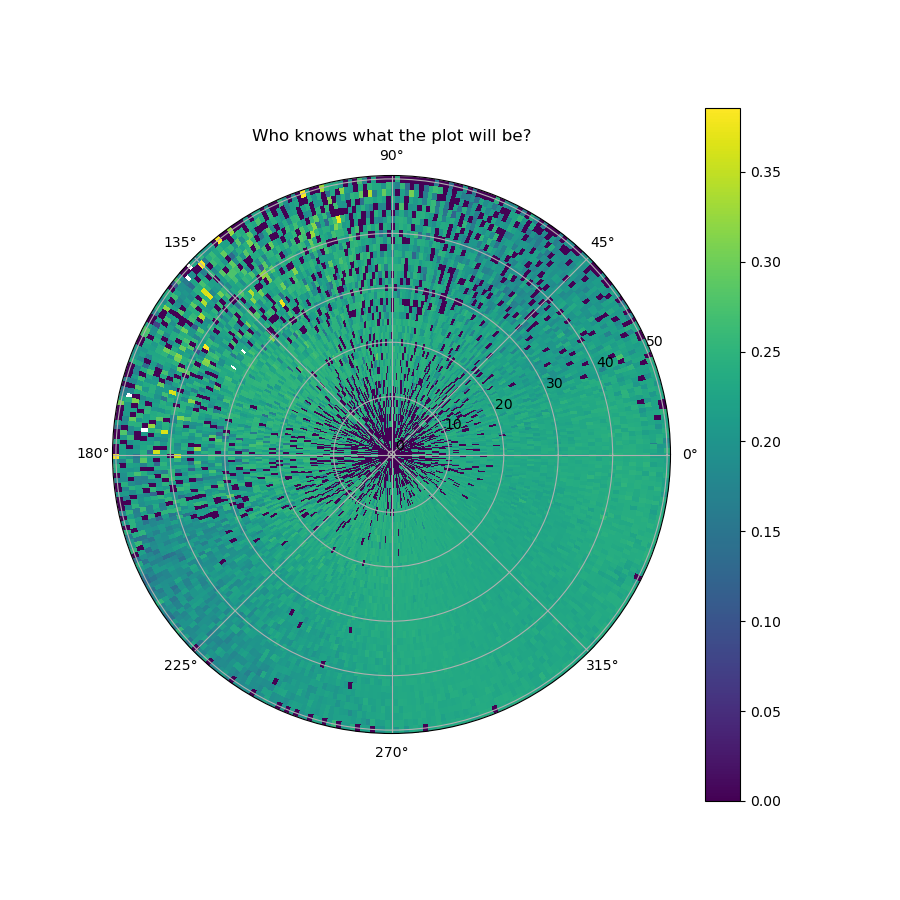

In [19]:
#PROGRAM
#NORTH POLE PLOTTER
#We ingest the CUBE EATER file. It is probably best not to hold it in RAM considering how large it can get.
#Read and act upon one line at a time. Which means we need to set up our framework ahead of time.
#Our "cells" are degrees of latitude and longitude.
#Our lon rage is over all 360 degrees.
#Our lat range is from 90 to 50, and only 50 if Kraken Mare is there. 

#PREREQS: the existence of CUBEEATERCSV.csv, and the imports at the top of this notebook.

compiledData = [[0 for x in range(360)] for x in range(41)]
multiplicity = [[0 for x in range(360)] for x in range(41)] #for tracking how many times our bins get a "hit"

target = -2 #10 corresponds to the 0.93 um window.

with open("CUBEEATERCSV2.csv") as csv_file:
        csv_reader = csv.reader(csv_file, delimiter=',')
        line_count = 0
        for row in csv_reader:
            if (line_count >= 2): #Ignore the header lines
                #First, find LatLon bins. 
                lat = float(row[3])
                lon = float(row[4])
                #Round to nearest whole number to get bins. 
                lat = round(lat)
                lon = round(lon)
                if (lon == 360):
                    lon = 0
                compiledData[lat-50][lon] = compiledData[lat-50][lon] + float(row[target])
                multiplicity[lat-50][lon] = multiplicity[lat-50][lon] + 1
            line_count += 1
            
#Now compiledData is not normalized. Do that.

i,j = 0,0
while (i < len(compiledData)):
    j = 0
    while (j < len(compiledData[i])):
        if(multiplicity[i][j] > 0): #Dividing by zero is genreally regarded as a bad idea. 
            compiledData[i][j] = compiledData[i][j] / multiplicity[i][j]
        j = j+1
    i = i+1
    
#Now DISPLAY!
#Display is in polar coordinates to give a good idea of what is actually going on.
#Polar assistance: https://stackoverflow.com/questions/73831636/pcolormesh-in-polar-coordinates-redux
fig, ax = plt.subplots(figsize = (9,9),subplot_kw=dict(projection='polar'))

#Now we do need to invert an axis.
i=0
while (i < len(compiledData)):
    compiledData[i] = np.flip(compiledData[i])
    i=i+1
compiledData = np.flip(compiledData)

phis2   = np.linspace(0.001,50,41) 
thetas2 = np.linspace(0,2.01*np.pi,360)
X,Y = np.meshgrid(thetas2,phis2)

image = ax.pcolormesh(X,Y,compiledData, cmap="viridis")
fig.colorbar(image,ax=ax)
ax.set(title = 'Who knows what the plot will be?') #Remove ticks.

plt.show()






<IPython.core.display.Javascript object>


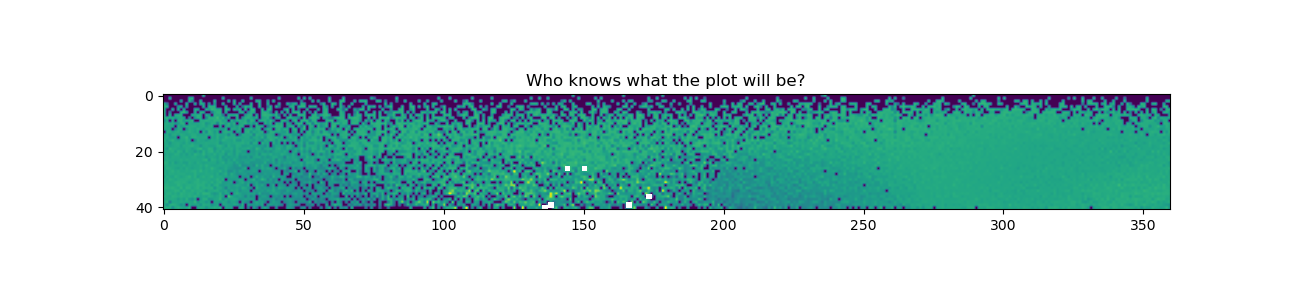

In [20]:
#Rectangular printing for sanity check.
fig, ax = plt.subplots(figsize = (13,3))

image = ax.imshow(compiledData, cmap="viridis")
#fig.colorbar(image,ax=ax)
# extent=[0,359,90,50]
# np.radians()
ax.set(title = 'Who knows what the plot will be?') #Remove ticks.

plt.show()

<IPython.core.display.Javascript object>


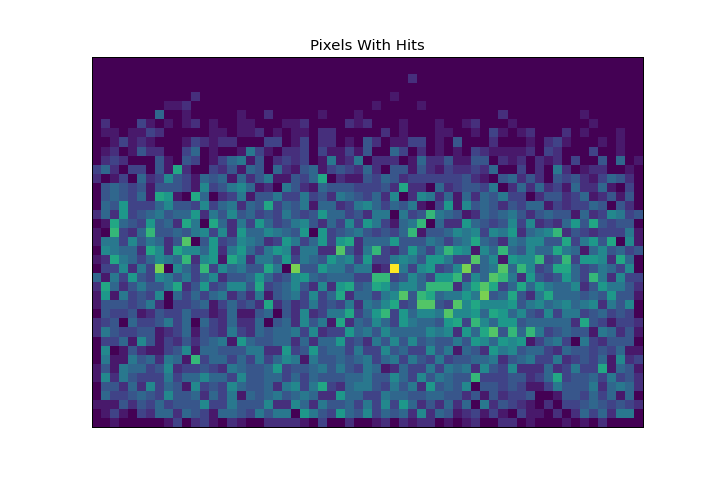

In [14]:
#This code here is meant to ingest cubes/image data and determine which pixels are
#of the same location at different viewing geometries, and then use those to 
#determine which locations are a better match for specular situations or not.

    #INPUTS

#Stuff the program user is supposed to mess with
lldivisions = 1 #how finely do we divide the bins? "1" is one bin for each lat-lon. "0.5" would be every half.
maxLat = 90
minLat = 50
maxLon = 340
minLon = 280 #Default this box is [90,50] and [340,280] for Lat and Lon respectively. Meant to capture Kraken.
#Make sure all four of the above are INTEGERS.
latTicks = int((maxLat-minLat)/lldivisions)+1
lonTicks = int((maxLon-minLon)/lldivisions)+1
#The +1 counts the "0" index; we are inclusive of both ends.

    #SETUP

#This program is complicated enough we need to declare the objects and data structures.
#The main storage is a 2D array in lat and lon. Every point in this array is a bin. Each bin contains every
#Pixel in that bin. The Pixels themselves need to be an object. 
#For dynamic declaration, we start by defining the Pixel class.
class Pixel:
    cube = " " #Cube of origin
    coors = [0.,0.] #Pixel coors in cube. 
    res = 0. #Resolution 
    inci = 0. #Incidence angle
    emis = 0. #Emission angle
    azim = 0. #Azimuth angle
    win0, win1, win2, win3, win4, win5, win6, win7 = 0.,0.,0.,0.,0.,0.,0.,0. #The intensity at the windows.
    #You may rightfully ask "why isn't this an array?" 
    #Answer: because for some reaosn when it's an array the memory gets rewritten after I read it in.
    #Solution: explicitly declare everything. Yes there most certainly is an array way to do it,
    #But I don't want to be here all day.
    winN0, winN1, winN2, winN3, winN4, winN5, winN6, winN7 = 0.,0.,0.,0.,0.,0.,0.,0. #Will hold the normalized window values.
    empty = 0 #Just a toggle, "0" means this is an empty pixel.
#No methods or functions at the moment, this is just a fancy data array for the most part. 
#In order to avoid implicit typing complications, let's make the array of arrays explicit.
#For this we will need an empty Pixel

dummy = Pixel()
bins = [[[dummy for x in range(2)] for x in range(lonTicks)] for x in range(latTicks)]
#stored as (lat,lon,pixel). Currently only 2 empty pixels at every location. This is to force
#the program to recognize it is an array of arrays. 
displayBin = [[0. for x in range(lonTicks)] for x in range(latTicks)]
#This one just holds the final image we will generate.

#Also calculate the relative sizes of everything so we can tell the figure what size to be later.
relDim = latTicks/lonTicks

    #READ IN INFO
with open("CUBEEATERCSV2.csv") as csv_file: #Open up the file with the curated data.
        csv_reader = csv.reader(csv_file, delimiter=',')
        line_count = 0
        for row in csv_reader:
            if (line_count >= 2): #Ignore the header lines                
                #First, we need to check if we actually need the pixel.
                #The coordinates are not actually stored on the pixel itself unlike most other data.
                lat = float(row[3])
                lon = float(row[4])
                
                #Only add the pixel if it is within our bounds. 
                #Otherwise do nothing.
                if (maxLat >= lat and minLat <= lat and maxLon >= lon and minLon <= lon):
                    
                    #Every line is a pixel that needs to be sorted. Let's get all of the pixel's attributes:
                    pixel = Pixel()
                    pixel.cube = row[0]
                    pixel.coors = [int(row[1]),int(row[2])]
                    pixel.res = float(row[8])
                    pixel.inci = float(row[5])
                    pixel.emis = float(row[6])
                    pixel.azim = float(row[7])

                    pixel.win0 = float(row[10])
                    pixel.win1 = float(row[11])
                    pixel.win2 = float(row[12])
                    pixel.win3 = float(row[13])
                    pixel.win4 = float(row[14])
                    pixel.win5 = float(row[15])
                    pixel.win6 = float(row[16])
                    pixel.win7 = float(row[17])

                    #Now the pixel also has a normalized value we store here.
                    #This normalization is accomplished by setting the sum of all 8 windows to 1.
                    #This removes any bias to "Brighter" or "Darker" images. 
                    pixelTotal = (pixel.win0 + pixel.win1 + pixel.win2 + pixel.win3
                                    + pixel.win4 + pixel.win5 + pixel.win6 + pixel.win7)

                    pixel.winN0 = pixel.win0/pixelTotal
                    pixel.winN1 = pixel.win1/pixelTotal
                    pixel.winN2 = pixel.win2/pixelTotal
                    pixel.winN3 = pixel.win3/pixelTotal
                    pixel.winN4 = pixel.win4/pixelTotal
                    pixel.winN5 = pixel.win5/pixelTotal
                    pixel.winN6 = pixel.win6/pixelTotal
                    pixel.winN7 = pixel.win7/pixelTotal

                    pixel.empty = 1 #This isn't an empty pixel. 
                    
                    if (pixel.res < 100): #Arbitrary "only high res data allowed" check
                        #Now that we HAVE the pixel's data, we need to cram it into our bins.
                        #We need the math to go from latlon to indices. 
                        ilat = 0 #lat index
                        ilon = 0 #lon index
                        tempA = 0. #Temporary angle storage during loop. 

                        tempA = minLat - lldivisions #subtracted to avoid an off by one error.
                        while (ilat <= latTicks):
                            tempA = tempA + lldivisions
                            if (tempA > lat):
                                if (tempA - lat > abs((tempA-lldivisions) - lat)):
                                    ilat = ilat-1 #This is the rounding check: which point is better? 
                                break
                            ilat = ilat+1
                        tempA = minLon - lldivisions #subtracted to avoid an off by one error.
                        while (ilon <= lonTicks):
                            tempA = tempA + lldivisions
                            if (tempA > lon):
                                if (tempA - lon > abs((tempA-lldivisions) - lon)):
                                    ilon = ilon-1 #This is the rounding check: which point is better? 
                                break
                            ilon = ilon+1

                        #We now have the coordinates of the bin our pixel is in.
                        if (len(bins[ilat][ilon]) == 2):
                            #Because of my awkward method of explicit definition, we have to check
                            #The first two additions manually.
                            if (bins[ilat][ilon][0].empty == 0):
                                bins[ilat][ilon][0] = pixel
                            elif (bins[ilat][ilon][1].empty == 0):
                                bins[ilat][ilon][1] = pixel
                            else:
                                #If both pixels are real, add a new one. 
                                bins[ilat][ilon].append(pixel)
                        else: 
                            #If this area already has a lot, append the pixel.
                            bins[ilat][ilon].append(pixel)

                    #And now we have completed reading in the data.
            line_count += 1

    #ASSEMBLE IMAGE

#The image itself can't be read directly out of our "bins", we need to tell it what to display.
#This will be altered later, but for now, we have a primitive display.
i,j = 0,0
while (i < latTicks):
    j = 0
    while (j < lonTicks):
        ans = 0. #For buffering our result.
        for pix in bins[i][j]:
            #Every pixel has a value, average it for this primitive mode.
            ans = ans + pix.win0
        displayBin[i][j] = len(bins[i][j])
        j = j+1
    i = i+1
    
    #DISPLAY
    
fig, ax = plt.subplots(figsize = (8,8*relDim))

image = ax.imshow(displayBin, cmap="viridis", origin="lower")
ax.set(title = 'Pixels With Hits', xticks = [], yticks = []) 
#Perhaps one day we shall add dynamic axes ticks... but for now leave them off.

plt.show()

<IPython.core.display.Javascript object>


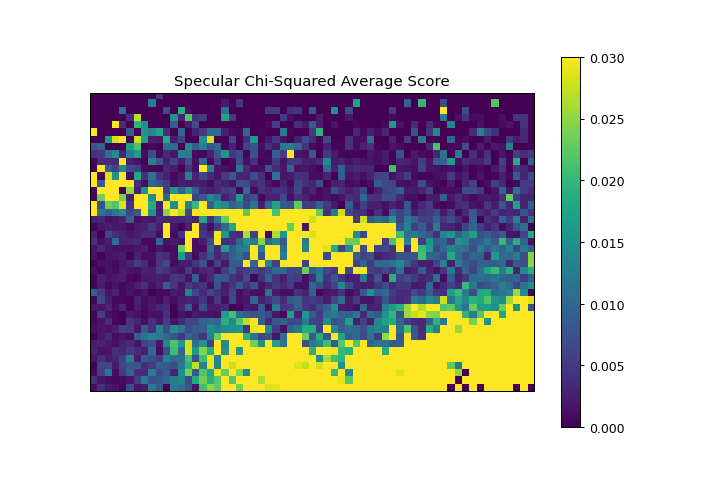

In [29]:
#As there is no reason to re-ingest the data every time we want to look at it, we split off the 
#ASSEMBLE IMAGE and DISPLAY sections here so they can be modified on their own.

    #ASSEMBLE IMAGE

#The image itself can't be read directly out of our "bins", we need to tell it what to display.
#This will be altered later, but for now, we have a primitive display.
i,j = 0,0
while (i < latTicks):
    j = 0
    while (j < lonTicks):
        ans = 0
        for pix in bins[i][j]:
            #We have selected a pixel at this point.
            #First, grab the data for all 8 windows. Store it in an array. Becasue now we can do that!
            pixelWindows = [pix.win0,pix.win1,pix.win2,pix.win3,pix.win4,pix.win5,pix.win6,pix.win7]
            normPixelWindows = [pix.winN0,pix.winN1,pix.winN2,pix.winN3,pix.winN4,pix.winN5,pix.winN6,pix.winN7]
            geomWindows = [0.,0.,0.,0.,0.,0.,0.,0.]
            geomWindowsL = [0.,0.,0.,0.,0.,0.,0.,0.]

            #Now we need to find the geometries for each pixel. Specifically:
            #incidence, emission, azimuth. 
            #These are contained within the geofiles.
            inci = pix.inci
            emis = pix.emis
            azim = pix.azim

            #We are now armed with i, e, and phi(azimuth); in addition to the 8 wavelengths. 
            #Each pixel contains 11 pieces of information. 
            #Now we need to grab the comparison information from the viewing geometries.
            #The viewing geometries are in divisions of five degrees, so first all values need to be rounded.
            inci = round(inci/5)*5
            emis = round(emis/5)*5
            azim = round(azim/5)*5
    
            #Now one thing we HAVEN'T done is load in the gometries of hte models.
            geomWindows[0] = dataWin1[int(inci / 5)][int(emis / 5)][int(azim / 5)]
            geomWindows[1] = dataWin2[int(inci / 5)][int(emis / 5)][int(azim / 5)]
            geomWindows[2] = dataWin3[int(inci / 5)][int(emis / 5)][int(azim / 5)]
            geomWindows[3] = dataWin4[int(inci / 5)][int(emis / 5)][int(azim / 5)]
            geomWindows[4] = dataWin5[int(inci / 5)][int(emis / 5)][int(azim / 5)]
            geomWindows[5] = dataWin6[int(inci / 5)][int(emis / 5)][int(azim / 5)]
            geomWindows[6] = dataWin7[int(inci / 5)][int(emis / 5)][int(azim / 5)]
            geomWindows[7] = dataWin8[int(inci / 5)][int(emis / 5)][int(azim / 5)]            
            geomWindowsL[0] = dataWin1L[int(inci / 5)][int(emis / 5)][int(azim / 5)]
            geomWindowsL[1] = dataWin2L[int(inci / 5)][int(emis / 5)][int(azim / 5)]
            geomWindowsL[2] = dataWin3L[int(inci / 5)][int(emis / 5)][int(azim / 5)]
            geomWindowsL[3] = dataWin4L[int(inci / 5)][int(emis / 5)][int(azim / 5)]
            geomWindowsL[4] = dataWin5L[int(inci / 5)][int(emis / 5)][int(azim / 5)]
            geomWindowsL[5] = dataWin6L[int(inci / 5)][int(emis / 5)][int(azim / 5)]
            geomWindowsL[6] = dataWin7L[int(inci / 5)][int(emis / 5)][int(azim / 5)]
            geomWindowsL[7] = dataWin8L[int(inci / 5)][int(emis / 5)][int(azim / 5)]
            #Maybe should have made the viewing geometry data in one array... oh well.
            #Anyway, that's all the data we need. Now comes the actual processing steps!
            
            score = 0 #To determine which is the best. Absurdly large at the start.
            scoreL = 0 #Lambertian as well.

            totalGeoLight = 0.
            totalGeoLightL = 0.
            for item in geomWindows:
                totalGeoLight = totalGeoLight + item
            for item in geomWindowsL:
                totalGeoLightL = totalGeoLightL + item
            #Now scale all the values
            #So the total for all of them is 1, like with the pixel normalization.
            normGeomWindows = np.array(geomWindows)/totalGeoLight
            normGeomWindowsL = np.array(geomWindowsL)/totalGeoLightL
            #Any bias for "dimmer" areas is now removed, everything is scaled to "total luminosity 1." 
            #This may break around specular points or errors, unsure. 
            #Also since we aren't performing a search this will be MUCH faster...
            
            #k=0
            #while (k<8):
                #score = score + (((normPixelWindows[k] - normGeomWindows[k])**2) / normGeomWindows[k])
                #scoreL = scoreL + (((normPixelWindows[k] - normGeomWindowsL[k])**2) / normGeomWindowsL[k])
                #k=k+1
            
            #The comparison is done with a chi-squared test.
            #k = 2
            #score = score + (((normPixelWindows[k] - normGeomWindows[k])**2) / normGeomWindows[k])
            #scoreL = scoreL + (((normPixelWindows[k] - normGeomWindowsL[k])**2) / normGeomWindowsL[k])
            #k = 4
            #score = score + (((normPixelWindows[k] - normGeomWindows[k])**2) / normGeomWindows[k])
            #scoreL = scoreL + (((normPixelWindows[k] - normGeomWindowsL[k])**2) / normGeomWindowsL[k])
            k = 7
            score = score + (((normPixelWindows[k] - normGeomWindows[k])**2) / normGeomWindows[k])
            scoreL = scoreL + (((normPixelWindows[k] - normGeomWindowsL[k])**2) / normGeomWindowsL[k])
            k=k+1

            if (inci == 0 and emis == 0 and azim == 0): #This ensures that the outside gets cut out.
                score = 0
                scoreL = 0
                #This also will block out one very specific type of direct specular point
                #This usually should not matter but be aware: (0,0,0) will be scraped.
            ans = ans + score
        displayBin[i][j] = ans/len(bins[i][j])
        j = j+1
    i = i+1
    
    #DISPLAY
    
fig, ax = plt.subplots(figsize = (8,8*relDim))

image = ax.imshow(displayBin, cmap="viridis", origin="lower",vmax=0.03)
ax.set(title = 'Specular Chi-Squared Average Score', xticks = [], yticks = []) 
fig.colorbar(image, ax=ax)
#Perhaps one day we shall add dynamic axes ticks... but for now leave them off.

plt.show()

#fig, ax = plt.subplots(figsize = (8,8*relDim))

#scale = 0.1

#image = ax.imshow(displayBin, cmap="seismic", origin="lower", vmin=-scale, vmax=scale)
#ax.set(title = 'Pixels With Hits', xticks = [], yticks = []) 

Lat: 61 Lon: 319
incidence emisssion azimuth resolution: 59.68664274002 60.25740438744467 30.88994052961371 82.02978127660296
CM_1848150755_1 Score Difference: 0.026451561561348348 

incidence emisssion azimuth resolution: 49.91600959104397 64.66217864285518 11.13349048174993 81.71475260325083
CM_1779051051_1 Score Difference: 0.059810986792377514 

incidence emisssion azimuth resolution: 49.72686129817153 64.52529001469799 10.564877440337057 84.55994445642122
CM_1779051576_1 Score Difference: 0.06700865605776965 

incidence emisssion azimuth resolution: 50.15149346085208 63.457513499488236 11.47671470100238 92.98867027752996
CM_1779053534_1 Score Difference: 0.05276145372502325 

incidence emisssion azimuth resolution: 92.38252914903163 38.90880557157244 104.72788104586427 49.19116568703926
CM_1757651454_1 Score Difference: 0.01279743516952031 

incidence emisssion azimuth resolution: 93.86819273003036 49.012030239816816 83.80578118518535 99.63302240247329
CM_1752122483_1 Score Differ

<IPython.core.display.Javascript object>


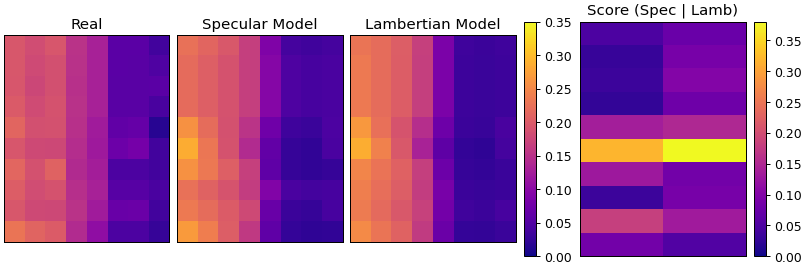

In [100]:
#So that didn't work, the lakes remain indistinguishable from the rest of the land here. 
#Let's just start looking at individual pixels. The above code will have to be run ahead of time, 
#As I'd rather not create ANOTHER ingesting method, the information is still in a useful form here.
#(42,5) 
#(7,17) 
x = 39
y = 11
#Choose the pixel this way.
print("Lat:", minLat+y, "Lon:", minLon+x)
size = len(bins[y][x])

realPixelData = [[0. for x in range(8)] for x in range(size)]
modelPixelData = [[0. for x in range(8)] for x in range(size)]
modelPixelDataL = [[0. for x in range(8)] for x in range(size)]
scoreData = [[0. for x in range(2)] for x in range(size)] #python didn't like trying to show a noodle image.

#And now we need to fill in the data. Not too difficult, just annoying. 
k = 0
for pix in bins[y][x]:
    realPixelData[k] = [pix.winN0,pix.winN1,pix.winN2,pix.winN3,pix.winN4,pix.winN5,pix.winN6,pix.winN7]

    #Now we need to find the geometries for each pixel. Specifically:
    #incidence, emission, azimuth. 
    #These are contained within the geofiles.
    inci = pix.inci
    emis = pix.emis
    azim = pix.azim          
    print("incidence emisssion azimuth resolution:", inci, emis, azim, pix.res)
    #We are now armed with i, e, and phi(azimuth); in addition to the 8 wavelengths. 
    #Each pixel contains 11 pieces of information. 
    #Now we need to grab the comparison information from the viewing geometries.
    #The viewing geometries are in divisions of five degrees, so first all values need to be rounded.
    inci = round(inci/5)*5
    emis = round(emis/5)*5
    azim = round(azim/5)*5

    #Now one thing we HAVEN'T done is load in the gometries of hte models.
    geomWindows[0] = dataWin1[int(inci / 5)][int(emis / 5)][int(azim / 5)]
    geomWindows[1] = dataWin2[int(inci / 5)][int(emis / 5)][int(azim / 5)]
    geomWindows[2] = dataWin3[int(inci / 5)][int(emis / 5)][int(azim / 5)]
    geomWindows[3] = dataWin4[int(inci / 5)][int(emis / 5)][int(azim / 5)]
    geomWindows[4] = dataWin5[int(inci / 5)][int(emis / 5)][int(azim / 5)]
    geomWindows[5] = dataWin6[int(inci / 5)][int(emis / 5)][int(azim / 5)]
    geomWindows[6] = dataWin7[int(inci / 5)][int(emis / 5)][int(azim / 5)]
    geomWindows[7] = dataWin8[int(inci / 5)][int(emis / 5)][int(azim / 5)]            
    geomWindowsL[0] = dataWin1L[int(inci / 5)][int(emis / 5)][int(azim / 5)]
    geomWindowsL[1] = dataWin2L[int(inci / 5)][int(emis / 5)][int(azim / 5)]
    geomWindowsL[2] = dataWin3L[int(inci / 5)][int(emis / 5)][int(azim / 5)]
    geomWindowsL[3] = dataWin4L[int(inci / 5)][int(emis / 5)][int(azim / 5)]
    geomWindowsL[4] = dataWin5L[int(inci / 5)][int(emis / 5)][int(azim / 5)]
    geomWindowsL[5] = dataWin6L[int(inci / 5)][int(emis / 5)][int(azim / 5)]
    geomWindowsL[6] = dataWin7L[int(inci / 5)][int(emis / 5)][int(azim / 5)]
    geomWindowsL[7] = dataWin8L[int(inci / 5)][int(emis / 5)][int(azim / 5)]
    #Maybe should have made the viewing geometry data in one array... oh well.
    #Anyway, that's all the data we need. Now comes the actual processing steps!

    score = 1000 #To determine which is the best. Absurdly large at the start.
    scoreL = 1000 #Lambertian as well.

    totalGeoLight = 0.
    totalGeoLightL = 0.
    for item in geomWindows:
        totalGeoLight = totalGeoLight + item
    for item in geomWindowsL:
        totalGeoLightL = totalGeoLightL + item
    #Now scale all the values
    #So the total for all of them is 1, like with the pixel normalization.
    modelPixelData[k] = np.array(geomWindows)/totalGeoLight
    modelPixelDataL[k] = np.array(geomWindowsL)/totalGeoLightL
    #Any bias for "dimmer" areas is now removed, everything is scaled to "total luminosity 1." 
    #This may break around specular points or errors, unsure. 
    #Also since we aren't performing a search this will be MUCH faster...
    
    #The comparison is done with a chi-squared test.
    j = 0
    score = 0
    scoreL = 0 #for holding the scores as they are added up.
    while (j<8):
        #print(modelPixelData[k])
        score = score + (((realPixelData[k][j] - modelPixelData[k][j])**2) / modelPixelData[k][j])
        scoreL = scoreL + (((realPixelData[k][j] - modelPixelDataL[k][j])**2) / modelPixelDataL[k][j])
        j=j+1

    if (inci == 0 and emis == 0 and azim == 0): #This ensures that the outside gets cut out.
        score = 0
        scoreL = 0
        #This also will block out one very specific type of direct specular point
        #This usually should not matter but be aware: (0,0,0) will be scraped.
    #print(score)
    scoreData[size-k-1][0] = score
    scoreData[size-k-1][1] = scoreL
    print(pix.cube, "Score Difference:", scoreL-score, "\n")
    #Due to differences in imshow and pcolormesh, things had to be inverted.
    
    k = k+1

#Now that we have everything, just... display!
fig, axs = plt.subplots(1,4, figsize = (9,3), layout = "constrained") 

maxVal = 0.35
cmap = "plasma"

axs[0].imshow(realPixelData, cmap=cmap,vmin=0,vmax=maxVal)
axs[1].imshow(modelPixelData, cmap=cmap,vmin=0,vmax=maxVal)
image = axs[2].imshow(modelPixelDataL, cmap=cmap,vmin=0,vmax=maxVal)
fig.colorbar(image,ax=axs[2])
image2 = axs[3].pcolormesh(scoreData, cmap=cmap,vmin=0)
fig.colorbar(image2,ax=axs[3])

axs[0].set(title = 'Real', xticks = [], yticks = []) 
axs[1].set(title = 'Specular Model', xticks = [], yticks = []) 
axs[2].set(title = 'Lambertian Model', xticks = [], yticks = []) 
axs[3].set(title = 'Score (Spec | Lamb)', xticks = [], yticks = []) 

#Perhaps one day we shall add dynamic axes ticks... but for now leave them off.

plt.show()

<IPython.core.display.Javascript object>


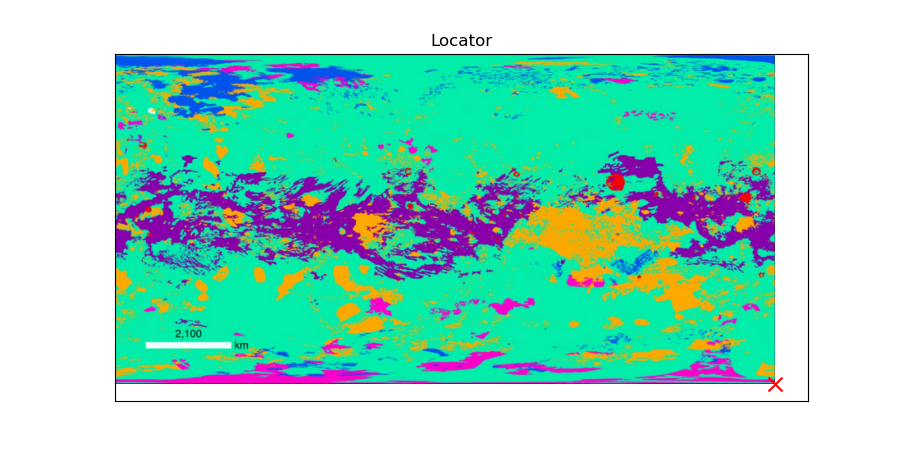

In [87]:
fig, ax = plt.subplots(figsize = (9,4.5))

img = mpimg.imread("TitanMap.png")
image = ax.imshow(img)

#The image is 805 in x and 402 in y
X = 805
Y = 402
#What we need is to plot lat lon based on all this nonsense.

#Hang on, what if I'm looking at all land...?

ax.scatter(805,402,color="red",marker="x",s=100)
ax.set(title = 'Locator', xticks = [], yticks = []) 
#Perhaps one day we shall add dynamic axes ticks... but for now leave them off.


plt.show()